In [1]:
!pip install /user-home/py_packages/catboost-0.6.3-cp27-none-manylinux1_x86_64.whl

In [3]:
import sys 
sys.path.append('/user-home/1014/code')
from eval_functions import *
from pdp import *

%matplotlib inline

import matplotlib.pyplot as plt

from __future__ import division
import numpy as np
np.random.seed(198908)
import pandas as pd

from sklearn.model_selection import cross_val_score,cross_val_predict
pd.set_option("display.max_columns",999)
from catboost import CatBoostClassifier,CatBoostRegressor,cv

import os
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"


import xgboost as xgb
import xgbfir
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.model_selection import PredefinedSplit,  cross_val_predict, GridSearchCV, StratifiedKFold, train_test_split, KFold , RandomizedSearchCV

from sklearn.externals import joblib

from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb 

from sklearn.feature_selection import SelectKBest, chi2

from pyearth  import Earth
from xgboost import XGBRegressor


import patsy
from patsy import dmatrix, build_design_matrices

from sklearn.linear_model import LogisticRegressionCV

def plot_single_var_response(X,var_name, response_name, bins):
    X['decile']=(bins)-(pd.qcut(X[var_name],bins,labels=False,duplicates='drop', ))
    bin_toPlot=X.groupby('decile')[response_name].mean()
    fig, ax = plt.subplots()
    ax.plot(bin_toPlot)
    ax.set_xlabel("Bin")
    ax.set_ylabel("Average Target")
    ax.legend()




def oversample_2class(x,y,prop,seed=0,save_msk_path=None, shuffle=True):
    
    y_pos=y.loc[(y.values).flatten()==1]
    x_pos =x.loc[(y.values).flatten()==1,:]
    
    nb_pos=y_pos.shape[0]
    nb_neg = (nb_pos / prop) - nb_pos
    
    ttl_neg=x.loc[(y.values).flatten()==0,:]
    np.random.seed(seed)
    indx_msk=np.random.choice(a=ttl_neg.shape[0], size=int(nb_neg),replace = False)
    
    sampled_negx=x.iloc[indx_msk,:]
    sampled_negy=y.iloc[indx_msk]
    
    finalx_df=pd.concat([x_pos,sampled_negx],axis=0)
    finaly_df=pd.concat([y_pos,sampled_negy],axis=0)
    
    
    if save_msk_path != None:
        joblib.dump(indx_msk,save_msk_path)
        
    
    if shuffle:
        indx_perm=np.random.permutation(finalx_df.shape[0])
        finalx_df=finalx_df.iloc[indx_perm,:]
        finaly_df=finaly_df.iloc[indx_perm,:]
        
        
        
    return(finalx_df,finaly_df)



from scipy.stats import randint as sp_randint, uniform






In [3]:
#gis=pd.read_csv('/user-home/1014/checking_models/response_rebuild/checking_model_gis.txt', na_values=['.', ' ','','null'])
#gis.head()



In [ ]:
full=pd.read_csv('/user-home/1014/checking_models/response_rebuild/checking_model_data.txt', na_values=['.', 'null'], dtype={'block_group':np.object, 'census_tract': np.object})
print(full.CAMPAIGN.value_counts())
print(full.responder.value_counts())

scores=pd.read_csv('/user-home/1014/checking_models/response_rebuild/scores.txt', na_values=['.', 'null'])
full=pd.merge(full,scores,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183'], right_on=['campaign','Person_Seq_No_1_183'])

add_tsp=pd.read_csv('/user-home/1014/checking_models/response_rebuild/additionaltsp.txt', na_values=['.', ' ','','null'])
print(add_tsp.CAMPAIGN.value_counts())
full=pd.merge(full,add_tsp,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183','date_key_link'], right_on=['CAMPAIGN','Person_Seq_No_1_183','Date_key_link'])

#gis=pd.read_csv('/user-home/1014/checking_models/response_rebuild/checking_model_gis.txt', na_values=['.', ' ','','null'])
#full=pd.merge(full,gis,how='left',left_on=['Person_Seq_No_1_183'], right_on=['Person_Seq'])

full['DMA_602']=np.where(full.DMA_176.values ==602,1,0)
full['DMA_539']=np.where(full.DMA_176.values ==539,1,0)
full['DMA_505']=np.where(full.DMA_176.values ==505,1,0)
full['DMA_510']=np.where(full.DMA_176.values ==510,1,0)
full['DMA_524']=np.where(full.DMA_176.values ==524,1,0)
full['DMA_534']=np.where(full.DMA_176.values ==534,1,0)
full['DMA_517']=np.where(full.DMA_176.values ==517,1,0)
full['DMA_535']=np.where(full.DMA_176.values ==535,1,0)
full['DMA_528']=np.where(full.DMA_176.values ==528,1,0)
full['DMA_515']=np.where(full.DMA_176.values ==515,1,0)
full['DMA_527']=np.where(full.DMA_176.values ==527,1,0)
full['DMA_563']=np.where(full.DMA_176.values ==563,1,0)
full['DMA_659']=np.where(full.DMA_176.values ==659,1,0)
full['DMA_571']=np.where(full.DMA_176.values ==571,1,0)
full['DMA_529']=np.where(full.DMA_176.values ==529,1,0)
full['DMA_542']=np.where(full.DMA_176.values ==542,1,0)
full['DMA_561']=np.where(full.DMA_176.values ==561,1,0)
full['DMA_548']=np.where(full.DMA_176.values ==548,1,0)
full['DMA_513']=np.where(full.DMA_176.values ==513,1,0)
full['DMA_547']=np.where(full.DMA_176.values ==547,1,0)
full['DMA_560']=np.where(full.DMA_176.values ==560,1,0)




full=full.drop([
#'CAMPAIGN',
'Cell',
'ACCT_KEY',
'hh_key',
#'Person_Seq_No_1_183',
'OPEN_DATE',
'date_key_link',
'full_census',
#'block_group',
'LAT',
'LNG',
#'ZIP_Code_13',
'Post_Office_Name_135',
#'State_Abbreviation_150',
'Contracted_Address_1836',
'census_tract_full',
'DATE_KEY',
#'census_tract',
    #'campaign',
    'Date_key_link','MT_Personal_Traveler_1480'#,'Orig_ID','Person_Seq'
],axis=1)


full.head()


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


decile_range
1    0.003647
2    0.003494
3    0.003168
4    0.002785
5    0.002742
6    0.002380
7    0.002387
8    0.002031
9    0.001787
10   0.001664
Name: responder, dtype: float64


,count,sum
decile_range,,
1,55109,201
2,73851,258
3,68178,216
4,60317,168
5,58708,161
6,55874,133
7,52373,125
8,43815,89
9,47572,85


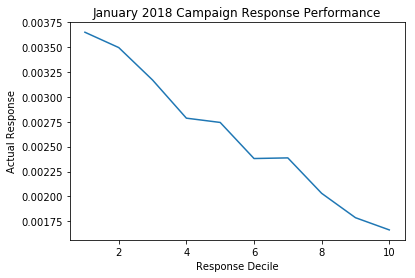

In [118]:
#performance of old model on Jan campaign
full_jan = full[(full.CAMPAIGN == 'JAN18')]


def resp_decile_classify(x): 
    if x >= 0.02016828: 
        resp_decile_range=1 
    elif x >=0.0183238479987624 and x < 0.02016828:
        resp_decile_range=2
    elif x >=0.0171368020008659 and x < 0.0183238479987624:
        resp_decile_range=3
    elif x >=0.0162066398244529 and x < 0.0171368020008659 :
        resp_decile_range=4
    elif x >=0.0153569084145478 and x < 0.0162066398244529:
        resp_decile_range=5    
    elif x >=0.0145335720355378 and x < 0.0153569084145478:
        resp_decile_range=6
    elif x >=0.0136686706768234 and x < 0.0145335720355378:
        resp_decile_range=7
    elif x >=0.0126610871036991 and x < 0.0136686706768234:
        resp_decile_range=8
    elif x >=0.0111844466793064 and x < 0.0126610871036991:
        resp_decile_range=9
    elif x < 0.0111844466793064:
        resp_decile_range=10
    
    return(resp_decile_range)

full_jan['decile_range']=full_jan.pred.apply(resp_decile_classify) 
v=full_jan.groupby('decile_range')['responder'].mean() 
print(v.head(n=20)) 
ax=v.plot(title='January 2018 Campaign Response Performance') 
ax.set_xlabel("Response Decile")
ax.set_ylabel("Actual Response")
full_jan.groupby('decile_range')['responder'].agg(['count','sum'])


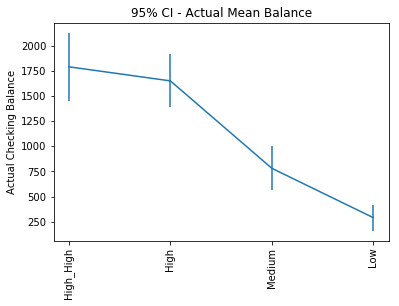

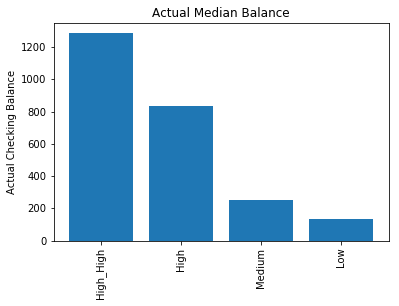

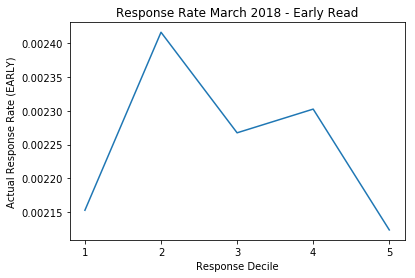

In [2]:
means=np.array([1791.89,1651.65,781.4,289.852459])
errors=[[336.6,263.01,218.8462332,129.5056978],[336.6,263.01,218.8462332,129.5056978]]
x=['High_High','High','Medium','Low']

fig, axs = plt.subplots()
plt.title("95% CI - Actual Mean Balance")
axs.errorbar(x=[1,2,3,4],y=means,yerr=errors)
#xx.show()
plt.xticks([1,2,3,4], x, rotation='vertical')
axs.set_ylabel("Actual Checking Balance")
plt.show()


fig, axs = plt.subplots()
plt.title("Actual Median Balance")
axs.bar(left=[1,2,3,4],height=[1284,834.5,250,134
])
plt.xticks([1,2,3,4], x, rotation='vertical')
axs.set_ylabel("Actual Checking Balance")
plt.show()



#fig, axs = plt.subplots()
#plt.title("Actual Trimmed Mean Balance (1/2% trim)")
#axs.bar(left=[1,2,3,4],height=[1200,800,252,159])
#axs.bar(left=[1,2,3,4],height=[1378.721,1330.407,696.6875,263.4118])
#plt.xticks([1,2,3,4], x, rotation='vertical')
#axs.set_ylabel("Actual Checking Balance")
#plt.show()



fig, axs = plt.subplots()
plt.title("Response Rate March 2018 - Early Read")
axs.plot([0.002152915,0.002416129,0.002267417,0.002302472,0.002123828])
axs.set_ylabel("Actual Response Rate (EARLY)")
axs.set_xlabel("Response Decile")
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.show()



In [ ]:

# Advantage_Target_Income_20_876   
d1={1:1,
2:2,
3:3,
4:4,
5:5,
6:6,
7:7,
8:8,
9:9,
'A':10,
'B':11,
'C':12,
'D':13
}


d2={'Y':1, 'N':0}

#target value score
d3={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0
}

#merit score,TriggerVal_ValueScore_1060
d4={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0,
'E1':10.0,
'E2':11.0,
'E3':12.0
}


d5={
'A':'10',
'B':'11',
'C':'12',
'D':'13'
}

d6={
'N':'0',
'D':'1',
'I':'-1',
}

d7={
'A':1.0,
    'B':2.0,
    'C':3.0,
    'D':4.0,
    'E':5.0,
    'F':6.0,
    'G':7.0,
    'H':8.0,
    'I':9.0,
    'J':10.0,
    'K':11.0,
    'L':12.0,
    'M':13.0,
    'N':14.0,
    'O':15.0,
    'P':16.0,
    'Q':17.0,
    'Z':18.0
            
}

full['TriggerVal_Home_Market_Valu_1002']=full.TriggerVal_Home_Market_Valu_1002.map(d7)



full['Credit_Card_Trigger_978']=full.Credit_Card_Trigger_978.fillna('N').map(d6)
full['Home_Market_Value_Trigger_1001']=full.Home_Market_Value_Trigger_1001.fillna('N').map(d6)
full['Income_Trigger_1009']=full.Income_Trigger_1009.fillna('N').map(d6)
full['ValueScore_Trigger_1059']=full.ValueScore_Trigger_1059.fillna('N').map(d6)
full['Niche_Switch_Trigger_1068']=full.Niche_Switch_Trigger_1068.fillna('N').map(d6)


#update when dict is not exhuastive (and is inplace!)
full['TriggerVal_Income_1010'].update(full['TriggerVal_Income_1010'].map(d5))
full['TriggerVal_Income_1010']=full['TriggerVal_Income_1010'].fillna('0').astype(float)





full['TriggerVal_ValueScore_1060']=full['TriggerVal_ValueScore_1060'].map(d4)  


full['Merit_Score_1881']=full['Merit_Score_1881'].map(d4)  

full['Mobility_Score_1878']=full['Mobility_Score_1878'].map(d4) 

full['Target_ValueScore_20_All_614']=full['Target_ValueScore_20_All_614'].map(d3)  
full['Target_ValueScore_20_Aut_616']=full['Target_ValueScore_20_Aut_616'].map(d3) 
full['Target_ValueScore_20_Ban_618']=full['Target_ValueScore_20_Ban_618'].map(d3)  
full['Target_ValueScore_20_Ret_620']=full['Target_ValueScore_20_Ret_620'].map(d3)  

full['Investments_and_Insurance_739'].fillna('N',inplace=True)
full['Investments_and_Insurance_744'].fillna('N',inplace=True)
full['Investments_and_Insurance_739']= full['Investments_and_Insurance_739'].map(d2)   
full['Investments_and_Insurance_744']= full['Investments_and_Insurance_744'].map(d2)  

full['Target_Home_Market_Value_894_v']=full.Target_Home_Market_Value_894.str[0:4].fillna(0).astype(float)  
full['Advantage_Target_Income_20_876']=full['Advantage_Target_Income_20_876'].map(d1)  


full['Current_Loan_to_Value_890']=full['Current_Loan_to_Value_890'].fillna(0).astype(float) 
full['Available_home_equity_in_th_899']=full['Available_home_equity_in_th_899'].fillna(0).astype(float)  
full['Advantage_Length_of_Residen_823']=full['Advantage_Length_of_Residen_823'].fillna(0).astype(float)  
full['Target_PreMover_20_Model_879']=full['Target_PreMover_20_Model_879'].fillna(0).astype(float)  

full['Gold_Wallets_1100'].fillna('N',inplace=True)
full['Silver_Wallets_1102'].fillna('N',inplace=True)
full['Platinum_Wallets_1101'].fillna('N',inplace=True)

full['Gold_Wallets_1100']= full['Gold_Wallets_1100'].map(d2)
full['Silver_Wallets_1102']= full['Silver_Wallets_1102'].map(d2) 
full['Platinum_Wallets_1101']= full['Platinum_Wallets_1101'].map(d2)   

full['Liquid_Resources_1093']=full['Liquid_Resources_1093'].astype(float)  
full['Wealth_Resources_1089']=full['Wealth_Resources_1089'].astype(float)  
full['Investment_Resources_1091']=full['Investment_Resources_1091'].astype(float)  


full['income_diff']=full['Advantage_Target_Income_20_876']-full['TriggerVal_Income_1010']

full=full.drop(['Target_Home_Market_Value_894'],axis=1)

full_jan_high = full[(full.CAMPAIGN == 'JAN18')&(full.Target_Net_Worth_20_881 >= 5)]
#d=np.column_stack([full_jan_high.responder.values,full_jan_high.pred.values]) #out of fold
#eval_model_results_binary(d,10)


def resp_decile_classify(x):
    if x >= 0.02016828:
        resp_decile_range=1
    elif x >=0.0183238479987624 and x <0.02016828 :
        resp_decile_range=2
    elif  x >= 0.0171368020008659 and x <0.0183238479987624  :
        resp_decile_range=3
    elif x >=0.0162066398244529 and x <0.0171368020008659:
        resp_decile_range=4
    elif x >= 0.0153569084145478 and x <0.0162066398244529 :
        resp_decile_range=5
    elif x >= 0.0145335720355378 and x <0.0153569084145478 :
        resp_decile_range=6
    elif x >= 0.0136686706768234 and x <0.0145335720355378 :
        resp_decile_range=7
    elif x >= 0.0126610871036991 and x <0.0136686706768234 :
        resp_decile_range=8
    elif x >= 0.0111844466793064 and x <0.0126610871036991 :
        resp_decile_range=9
    elif x < 0.0111844466793064:
        resp_decile_range=10
    
    return(resp_decile_range)



full_jan_high['decile_range']=full_jan_high.pred.apply(resp_decile_classify)
v=full_jan_high.groupby('decile_range')['responder'].mean()
print(v.head(n=20))
v.plot()
full_jan_high.groupby('decile_range')['responder'].agg(['count','sum'])

full_jan_high = full[(full.CAMPAIGN == 'JAN18')&(full.Target_Net_Worth_20_881 < 5)]
full_jan_high['decile_range']=full_jan_high.pred.apply(resp_decile_classify)
v=full_jan_high.groupby('decile_range')['responder'].mean()
print(v.head(n=20))
v.plot()
full_jan_high.groupby('decile_range')['responder'].agg(['count','sum'])

In [6]:
#seperate out march
marchX=full[full.CAMPAIGN == 'MAR17'].drop('responder',axis=1)
marchy=full[full.CAMPAIGN == 'MAR17']['responder']


full =full[full.CAMPAIGN != 'MAR17']


#marchX=marchX.drop('CAMPAIGN',axis=1)
#full=full.drop('CAMPAIGN',axis=1)

In [7]:
#random sample (no under-sampling) for a test set

msk_test = np.random.rand(len(full)) < 0.25
x_test = full[msk_test].drop('responder' ,axis=1)
y_test = full[msk_test].responder

x_test.to_csv('/user-home/1014/checking_models/response_rebuild/X_test.csv',header=True,index=False)
y_test.to_csv('/user-home/1014/checking_models/response_rebuild/y_test.csv',header=True,index=False)

joblib.dump(msk_test,'/user-home/1014/checking_models/response_rebuild/msk_test.mask')

['/user-home/1014/checking_models/response_rebuild/msk_test.mask']

In [8]:
#non-test
remain=full[~msk_test]

del full


msk_dev = np.random.rand(len(remain)) < 0.25

x_dev = remain[msk_dev].drop('responder' ,axis=1)
y_dev = remain[msk_dev].responder

x_train = remain[~msk_dev].drop('responder' ,axis=1)
y_train = remain[~msk_dev].responder

#add march to training
x_train=pd.concat([x_train,marchX],axis=0)
y_train=pd.concat([y_train,marchy],axis=0)


x_dev.to_csv('/user-home/1014/checking_models/response_rebuild/X_dev.csv',header=True,index=False)
y_dev.to_csv('/user-home/1014/checking_models/response_rebuild/y_dev.csv',header=True,index=False)

x_train.to_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv',header=True,index=False)
y_train.to_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv',header=True,index=False)


joblib.dump(msk_dev,'/user-home/1014/checking_models/response_rebuild/msk_dev.mask')

del remain

In [10]:
x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')

x_dev =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_dev.csv')
y_dev =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_dev.csv')

x_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_test.csv')
y_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_test.csv')




def load_dat():
    x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
    y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')

    x_dev =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_dev.csv')
    y_dev =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_dev.csv')

    x_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_test.csv')
    y_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_test.csv')

    
    return(x_train,y_train,x_dev,y_dev,x_test,y_test)

In [11]:
x_train['MDM_household_Share_BG_ixi']=x_train['MDM_household_Share_BG'] / x_train['total']
x_train['PEN_CHECK']=x_train['SUM_CHECKING_IND_BG'] / x_train['total_ixi_check_custs']
x_train['peraddress_53']=x_train['sum_fifth_third'] / x_train['addresses_CT']
x_train['peraddress_bc']=x_train['total_bankingcenters'] / x_train['addresses_CT']
x_train['checking_pen_53_MA_Custs']=x_train['checking_MA']/x_train['MA']
x_train['checking_pen_53_MA_Custs_BG']=x_train['checking_MA_BG']/x_train['MA_BG']

x_dev['MDM_household_Share_BG_ixi']=x_dev['MDM_household_Share_BG'] / x_dev['total']
x_dev['PEN_CHECK']=x_dev['SUM_CHECKING_IND_BG'] / x_dev['total_ixi_check_custs']
x_dev['peraddress_53']=x_dev['sum_fifth_third'] / x_dev['addresses_CT']
x_dev['peraddress_bc']=x_dev['total_bankingcenters'] / x_dev['addresses_CT']
x_dev['checking_pen_53_MA_Custs']=x_dev['checking_MA']/x_dev['MA']
x_dev['checking_pen_53_MA_Custs_BG']=x_dev['checking_MA_BG']/x_dev['MA_BG']

x_test['MDM_household_Share_BG_ixi']=x_test['MDM_household_Share_BG'] / x_test['total']
x_test['PEN_CHECK']=x_train['SUM_CHECKING_IND_BG'] / x_test['total_ixi_check_custs']
x_test['peraddress_53']=x_test['sum_fifth_third'] / x_test['addresses_CT']
x_test['peraddress_bc']=x_test['total_bankingcenters'] / x_test['addresses_CT']
x_test['checking_pen_53_MA_Custs']=x_test['checking_MA']/x_test['MA']
x_test['checking_pen_53_MA_Custs_BG']=x_test['checking_MA_BG']/x_test['MA_BG']

#pd.Series(x_train.columns).to_csv('/user-home/1014/checking_models/response_rebuild/columns.csv', index=False)

#prepare test set
x_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_test.csv')
y_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_test.csv')
x_test['MDM_household_Share_BG_ixi']=x_test['MDM_household_Share_BG'] / x_test['total']
x_test['PEN_CHECK']=x_test['SUM_CHECKING_IND_BG'] / x_test['total_ixi_check_custs']
x_test['peraddress_53']=x_test['sum_fifth_third'] / x_test['addresses_CT']
x_test['peraddress_bc']=x_test['total_bankingcenters'] / x_test['addresses_CT']

x_test=x_test.drop(['pred','campaign','block_group','Advantage_Individual_Age_1_262'],axis=1)

<h3>Sampling for all NW</h3>

In [10]:
# single model, train on train, test on dev

#x_train2=x_train.drop(['pred','campaign','block_group','Advantage_Individual_Age_1_262'],axis=1)
#x_dev2=x_dev.drop(['pred','campaign','block_group','Advantage_Individual_Age_1_262'],axis=1)

#oversample training
x_train2, y_train2 = oversample_2class(x=x_train,y=y_train,prop=0.05,seed=12458,save_msk_path=None, shuffle=True)

In [11]:
del x_train
#del x_dev
del x_test
del y_test
del y_train

x_train2.to_csv('/user-home/1014/checking_models/response_rebuild/x_train_oversample.csv', index=False)
y_train2.to_csv('/user-home/1014/checking_models/response_rebuild/y_train_oversample.csv', index=False)


In [ ]:
x_train2=pd.read_csv('/user-home/1014/checking_models/response_rebuild/x_train_oversample.csv')
y_train2=pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train_oversample.csv')


<h3>Sampling for only high NW</h3>

In [5]:
#x_train.shape
#y_train.shape
x_train.head()

,CAMPAIGN,Person_Seq_No_1_183,block_group,DMA_176,Number_of_Tradelines_1_261,Advantage_Individual_Age_1_262,Target_ValueScore_20_All_614,Target_ValueScore_20_Aut_616,Target_ValueScore_20_Ban_618,Target_ValueScore_20_Ret_620,Investments_and_Insurance_739,Investments_and_Insurance_744,Advantage_Home_Owner_813,Advantage_Length_of_Residen_823,Advantage_Target_Income_20_876,Target_PreMover_20_Model_879,Target_Net_Worth_20_881,Target_Income_Index_20_882,Current_Loan_to_Value_890,Available_home_equity_in_th_899,Home_equity_loan_in_thousan_913,Home_Market_Value_Tax_Reco_918,Second_mortgage_amount_in_t_950,Wealth_Resources_1089,Investment_Resources_1091,Liquid_Resources_1093,Gold_Wallets_1100,Platinum_Wallets_1101,Silver_Wallets_1102,MT_401k_Owners_1148,MT_Credit_Card_Balance_Tr_1254,MT_Credit_Card_Revolvers_1256,collapsed_niche_indx,addresses_BG,addresses_CT,sum_Fullservice_Branch_YesNo,sum_NonRetail_Bank_Branch_YesNo,sum_Denovo_Branch_YesNo,sum_InStore_Branch_YesNo,sum_Headquarters_YesNo,sum_fifth_third,sum_peer,sum_core,sum_trill,sum_CU,total_bankingcenters,avg_Fullservice_Branch_YesNo,avg_NonRetail_Bank_Branch_YesNo,avg_Denovo_Branch_YesNo,avg_InStore_Branch_YesNo,avg_Headquarters_YesNo,avg_fifth_third,avg_peer,avg_core,sum_BBT_Corporation,sum_CapitalOne,sum_Comerica,sum_Huntington,sum_KeyCorp,sum_MTBank,sum_PNC,sum_Regions,sum_SunTrust,sum_USBancorp,sum_WellsFargo,sum_Zions,sum_JPMorganChase,avg_BBT_Corporation,avg_CapitalOne,avg_Comerica,avg_Huntington,avg_KeyCorp,avg_MTBank,avg_PNC,avg_Regions,avg_SunTrust,avg_USBancorp,avg_WellsFargo,avg_Zions,avg_JPMorganChase,avg_CU,total_tape_deposits,NonCU_total_tape_deposits,total_tape_deposits_53,ratio_53_total,ratio_peer_total,ratio_core_total,ratio_CU_total,ratio_53_peer,ratio_53_core,ratio_53_trill,ratio_53_tape_total,ratio_53_tape_NonCU,CD_excludeIRA_AVG_VALUE,CD_IncludeIRA_AVG_VALUE,Fixed_int_Save_exlcudeIRA_AVG_VA,MM_Save_AVG_VALUE,Reg_Liq_Sav_excludeIRA_AVG_VALUE,Savings_AVG_VALUE,VI_Save_excludeIRA_AVG_VALUE,InterDDA_AVG_VALUE,Reg_nonInt_DDA_AVG_VALUE,TransDDA_AVG_VALUE,Deposit_AVG_VALUE,LiquidDep_AVG_VALUE,Ass_CashMan_AVG_VALUE,CD_excludeIRA_Households,CD_IncludeIRA_Households,Fixed_int_Save_exlcudeIRA_Househ,MM_Save_Households,Reg_Liq_Sav_excludeIRA_Household,Savings_Households,VI_Save_excludeIRA_Households,InterDDA_Households,Reg_nonInt_DDA_Households,TransDDA_Households,Deposit_Households,LiquidDep_Households,Ass_CashMan_Households,CD_IncludeIRA_TOTAL,Fixed_int_Save_exlcudeIRA_TOTAL,MM_Save_TOTAL,Reg_Liq_Sav_excludeIRA_TOTAL,Savings_TOTAL,VI_Save_excludeIRA_TOTAL,InterDDA_TOTAL,Reg_nonInt_DDA_TOTAL,TransDDA_TOTAL,Deposit_TOTAL,LiquidDep_TOTAL,Ass_CashMan_TOTAL,A01,A02,A03,A04,B05,B06,B07,B08,C09,C10,C11,C12,D13,D14,D15,D16,E17,E18,E19,E20,F21,F22,F23,F24,G25,G26,G27,G28,H29,H30,H31,I32,J33,J34,J35,J36,K37,K38,K39,L40,L41,L42,M43,M44,M45,M46,M47,N48,N49,N50,N51,O52,O53,P54,P55,P56,P57,Q58,Q59,Q60,R61,total,FE,MA,MM,UB,prop_FE,prop_MA,prop_MM,prop_UB,propA01,propA02,propA03,propA04,propB05,propB06,propB07,propB08,propC09,propC10,propC11,propC12,propD13,propD14,propD15,propD16,propE17,propE18,propE19,propE20,propF21,propF22,propF23,propF24,propG25,propG26,propG27,propG28,propH29,propH30,propH31,propI32,propJ33,propJ34,propJ35,propJ36,propK37,propK38,propK39,propL40,propL41,propL42,propM43,propM44,propM45,propM46,propM47,propN48,propN49,propN50,propN51,propO52,propO53,propP54,propP55,propP56,propP57,propQ58,propQ59,propQ60,propR61,ixi_check_custs_A01,ixi_check_custs_A02,ixi_check_custs_A03,ixi_check_custs_A04,ixi_check_custs_B05,ixi_check_custs_B06,ixi_check_custs_B07,ixi_check_custs_B08,ixi_check_custs_C09,ixi_check_custs_C10,ixi_check_custs_C11,ixi_check_custs_C12,ixi_check_custs_D13,ixi_check_custs_D14,ixi_check_custs_D15,ixi_check_custs_D16,ixi_check_custs_E17,ixi_check_custs_E18,ixi_check_custs_E19,ixi_check_custs_E20,ixi_check_custs_F21,ixi_check_custs_F22,ixi_check_custs_F23,ixi_check_custs_F24,ixi_check_custs_G25,ixi_check_custs_G26,ixi_check_custs_G27,ixi_check_custs_G28,

In [6]:
x_train2=x_train.copy().drop(['CAMPAIGN','Person_Seq_No_1_183','pred','DMA_176','campaign','block_group','Advantage_Individual_Age_1_262'],axis=1)
x_dev2=x_dev.copy().drop(['CAMPAIGN','Person_Seq_No_1_183','pred','DMA_176','campaign','block_group','Advantage_Individual_Age_1_262'],axis=1)


x_train2= x_train2[x_train2.Target_Net_Worth_20_881 >= 5]
y_train2= y_train[x_train.Target_Net_Worth_20_881 >= 5]
x_dev2_HNW= x_dev2[x_dev2.Target_Net_Worth_20_881 >= 5]
y_dev2_HNW = y_dev[x_dev2.Target_Net_Worth_20_881 >= 5]

#oversample training
x_train2_HNW, y_train2_HNW = oversample_2class(x=x_train2,y=y_train2,prop=0.025,seed=12458,save_msk_path=None, shuffle=True)



del x_train
del x_dev
del x_test
del y_test
del y_train

x_train2_HNW.to_csv('/user-home/1014/checking_models/response_rebuild/x_train2_HNWoversample.csv', index=False)
y_train2_HNW.to_csv('/user-home/1014/checking_models/response_rebuild/y_train2_HNWoversample.csv', index=False)
x_dev2.to_csv('/user-home/1014/checking_models/response_rebuild/x_dev2_HNWoversample.csv', index=False)
y_dev.to_csv('/user-home/1014/checking_models/response_rebuild/y_dev_HNWoversample.csv', index=False)



In [111]:
x_train2_HNW=pd.read_csv('/user-home/1014/checking_models/response_rebuild/x_train2_HNWoversample.csv')
y_train2_HNW=pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train2_HNWoversample.csv')
x_dev2=pd.read_csv('/user-home/1014/checking_models/response_rebuild/x_dev2_HNWoversample.csv')
y_dev=pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_dev_HNWoversample.csv')

In [40]:
pd.DataFrame(x_train2_HNW.columns,columns=['col']).to_csv('/user-home/1014/checking_models/response_rebuild/HNW_cols.csv',index=False)

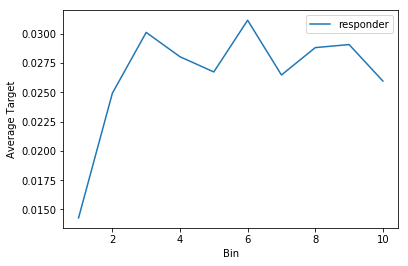

In [80]:
xcom=pd.concat([x_train2_HNW,y_train2_HNW],axis=1)
#xcom=pd.concat([x_train[x_train.Target_Net_Worth_20_881 < 5],y_train[x_train.Target_Net_Worth_20_881 < 5]],axis=1)
xcom['checking_pen_53_MA_Custs']=xcom['checking_MA']/xcom['MA']
xcom['checking_pen_53_MA_Custs_BG']=xcom['checking_MA_BG']/xcom['MA_BG']
xcom.shape
plot_single_var_response(xcom,'distance','responder',10)
#x_train2_HNW.distance.describe()

keep_vars_linear=['MDM_hsld_ShrNEW24',
'Target_Home_Market_Value_894_v',
'Advantage_Target_Income_20_876',
'distance',
'MDM_household_Share_BG_ixi',
'MDM_CKBAL_ShareIXI_BG',
'Target_PreMover_20_Model_879',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_hsld_ShrNEW24CHK24',
'prop_MM',
'Advantage_Length_of_Residen_823',
'new_hhs_24',
'PEN_CHECK',
   'DMA_505',
'DMA_510',
'DMA_513',
'DMA_515',
'DMA_517',
'DMA_524',
'DMA_527',
'DMA_528',
'DMA_529',
'DMA_534',
'DMA_535',
'DMA_539',
'DMA_542',
'DMA_547',
'DMA_548',
'DMA_560',
'DMA_561',
'DMA_563',
'DMA_571',
'DMA_602',
'DMA_659',
'Merit_Score_1881',
'Mobility_Score_1878',
                  'new_hhs_12_with_checking',
                  
'ratio_53_core',
'ratio_53_peer',
'ratio_53_tape_NonCU',
'ratio_53_tape_total',
'peraddress_53',
                  'peraddress_bc',
                  'MDM_CKhousehold_ShareFE_BG',
                  'checking_pen_53_MA_Custs_BG',
                  'checking_pen_53_MA_Custs'

               
]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 18.5min finished


{'depth': 5, 'learning_rate': 0.01}
AUC is: 0.581253653088
KS: 0.121195549801
Total Responders: 566.0
Lift Bin 1 (Vs Mean): 1.4664384596
Lift Bin 1 (Vs Last Bin): 2.86221269419


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,19913,83,0.004168,0.053254,1.466438,19913,83,0.004168,1.466438,0.051539,0.063472
1,2,19913,75,0.003766,0.050678,1.325095,39826,158,0.003967,1.395767,0.049934,0.051539
2,3,19913,68,0.003415,0.049314,1.201419,59739,226,0.003783,1.330984,0.048736,0.049934
3,4,19913,62,0.003114,0.048191,1.095412,79652,288,0.003616,1.272091,0.047662,0.048736
4,5,19913,61,0.003063,0.047122,1.077744,99565,349,0.003505,1.233222,0.046584,0.047662
5,6,19913,59,0.002963,0.046032,1.042408,119478,408,0.003415,1.201419,0.045469,0.046584
6,7,19910,43,0.002160,0.044848,0.759836,139388,451,0.003236,1.138344,0.044202,0.045469
7,8,19916,51,0.002561,0.043464,0.900929,159304,502,0.003151,1.108663,0.042686,0.044202
8,9,19913,35,0.001758,0.041719,0.618378,179217,537,0.002996,1.054187,0.040502,0.042686
9,10,19914,29,0.001456,0.037970,0.512344,199131,566,0.002842,1.000000,0.031559,0.040501


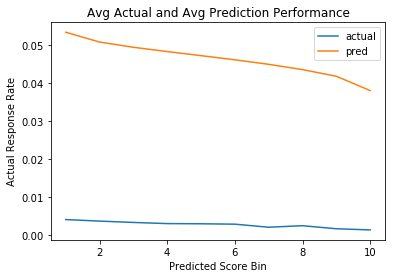

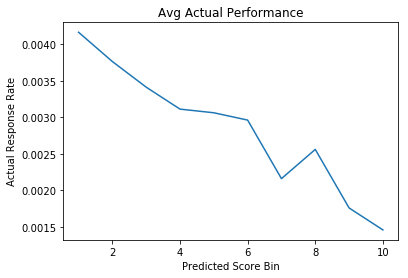

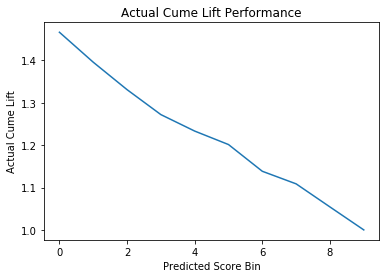

In [7]:
#use the val as early stopping CATBOOST

x_train2_HNW=x_train2_HNW.drop(['SamplingWeight','INTERNET_BANKING_IND',
'INTERNET_BANKING_IND_BG',
'MOBI_IND',
'MOBI_IND_BG',
'SamplingWeight',
'SelectionProb'],axis=1).fillna(-999)
x_dev2=x_dev2.drop(['SamplingWeight','INTERNET_BANKING_IND',
'INTERNET_BANKING_IND_BG',
'MOBI_IND',
'MOBI_IND_BG',
'SamplingWeight',
'SelectionProb'],axis=1).fillna(-999)

keep_vars_linear=['MDM_hsld_ShrNEW24',
'Target_Home_Market_Value_894_v',
'Advantage_Target_Income_20_876',
'distance',
'MDM_household_Share_BG_ixi',
'MDM_CKBAL_ShareIXI_BG',
'Target_PreMover_20_Model_879',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_hsld_ShrNEW24CHK24',
'prop_MM',
'Advantage_Length_of_Residen_823',
'new_hhs_24',
'PEN_CHECK',
   'DMA_505',
'DMA_510',
'DMA_513',
'DMA_515',
'DMA_517',
'DMA_524',
'DMA_527',
'DMA_528',
'DMA_529',
'DMA_534',
'DMA_535',
'DMA_539',
'DMA_542',
'DMA_547',
'DMA_548',
'DMA_560',
'DMA_561',
'DMA_563',
'DMA_571',
'DMA_602',
'DMA_659',
'Merit_Score_1881',
'Mobility_Score_1878',
                  'new_hhs_12_with_checking',
                  
'ratio_53_core',
'ratio_53_peer',
'ratio_53_tape_NonCU',
'ratio_53_tape_total',
'peraddress_53',
                  'peraddress_bc',
                  'MDM_CKhousehold_ShareFE_BG',
                  'checking_pen_53_MA_Custs_BG',
                  #'checking_pen_53_MA_Custs'

               
]

x_train2_HNW=x_train2_HNW[keep_vars_linear].fillna(-999)
x_dev2=x_dev2[keep_vars_linear].fillna(-999)


#mod_=LogisticRegressionCV()
#mod_.fit(x_train2_HNW.values,y_train2_HNW.values)
param_grid = {
'depth': [5,7,9],'learning_rate':[0.01]
}



fit_dict = {"eval_set":(x_dev2, y_dev), "use_best_model":True}
      
#small grid search for the best params
clf_cat=CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.05, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod_gs=GridSearchCV(clf_cat,param_grid=param_grid , n_jobs=1, cv=3,scoring='roc_auc',verbose=True )
mod_gs.fit(X=x_train2_HNW, y=y_train2_HNW.values.ravel(),**fit_dict)

#the final model fit (best params) will also employ early stopping
print(mod_gs.best_params_)

preds=mod_gs.best_estimator_.predict_proba(x_dev2)[:,1]
d=np.column_stack([y_dev.values,preds]) #out of fold
eval_model_results_binary(d,10)








AUC is: 0.548339972824
KS: 0.0805273887694
Total Responders: 229.0
Lift Bin 1 (Vs Mean): 1.44106165285
Lift Bin 1 (Vs Last Bin): 1.57157707158


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,10582,33,0.003119,0.050956,1.441062,10582,33,0.003119,1.441062,0.049365,0.060060
1,2,10582,31,0.002930,0.048615,1.353725,21164,64,0.003024,1.397393,0.047949,0.049365
2,3,10582,22,0.002079,0.047416,0.960708,31746,86,0.002709,1.251831,0.046918,0.047949
3,4,10582,24,0.002268,0.046470,1.048045,42328,110,0.002599,1.200885,0.046024,0.046918
4,5,10582,17,0.001607,0.045589,0.742365,52910,127,0.002400,1.109181,0.045160,0.046024
5,6,10582,21,0.001985,0.044716,0.917039,63492,148,0.002331,1.077157,0.044263,0.045160
6,7,10582,23,0.002174,0.043788,1.004376,74074,171,0.002309,1.066760,0.043297,0.044263
7,8,10582,18,0.001701,0.042736,0.786034,84656,189,0.002233,1.031669,0.042129,0.043297
8,9,10582,19,0.001796,0.041356,0.829702,95238,208,0.002184,1.009228,0.040421,0.042129
9,10,10583,21,0.001984,0.038363,0.916953,105821,229,0.002164,1.000000,0.031714,0.040421


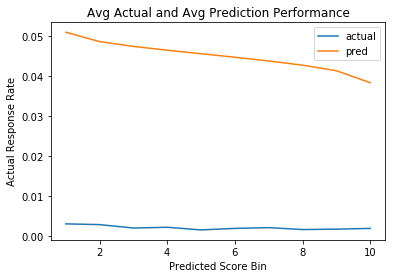

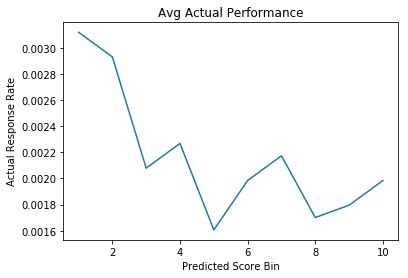

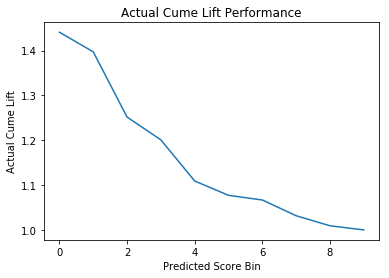

In [13]:
#test set


x_test2=x_test[x_test.Target_Net_Worth_20_881 >= 5][keep_vars_linear].fillna(-999)
preds=mod_gs.best_estimator_.predict_proba(x_test2)[:,1]
d=np.column_stack([y_test[x_test.Target_Net_Worth_20_881 >= 5].values,preds]) #out of fold
eval_model_results_binary(d,10)

In [ ]:
#build on entire training, dev and test for scooring march 18

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,38,39,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


AUC is: 0.519952924211
KS: 0.0361991442806
Total Responders: 5510.0
Lift Bin 1 (Vs Mean): 1.07077862247
Lift Bin 1 (Vs Last Bin): 1.19675456389


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,241057,590,0.002448,0.052715,1.070779,241057,590,0.002448,1.070779,0.051200,0.063292
1,2,241050,587,0.002435,0.050504,1.065365,482107,1177,0.002441,1.068072,0.049925,0.051200
2,3,241063,593,0.002460,0.049465,1.076196,723170,1770,0.002448,1.070780,0.049037,0.049925
3,4,241056,559,0.002319,0.048653,1.014522,964226,2329,0.002415,1.056716,0.048282,0.049037
4,5,241057,605,0.002510,0.047924,1.098002,1205283,2934,0.002434,1.064973,0.047564,0.048282
5,6,241056,571,0.002369,0.047195,1.036300,1446339,3505,0.002423,1.060194,0.046818,0.047564
6,7,241057,539,0.002236,0.046411,0.978220,1687396,4044,0.002397,1.048483,0.045987,0.046818
7,8,241056,513,0.002128,0.045516,0.931037,1928452,4557,0.002363,1.033803,0.045020,0.045987
8,9,241057,460,0.001908,0.044426,0.834844,2169509,5017,0.002313,1.011696,0.043742,0.045020
9,10,241057,493,0.002045,0.042368,0.894735,2410566,5510,0.002286,1.000000,0.034281,0.043742


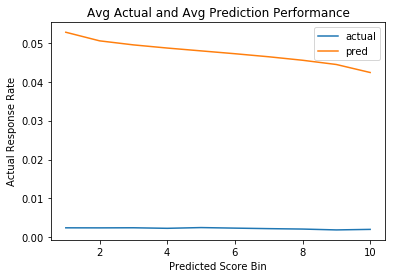

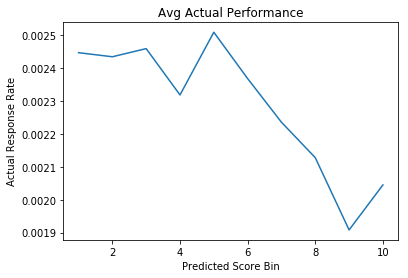

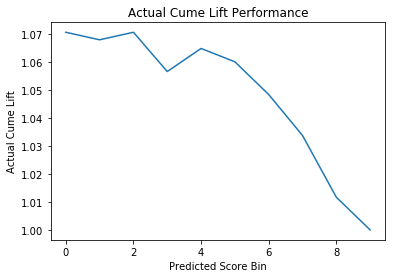

In [8]:
test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/MAR_18_checking_model_data.txt')

test['DMA_602']=np.where(test.DMA_176.values ==602,1,0)
test['DMA_539']=np.where(test.DMA_176.values ==539,1,0)
test['DMA_505']=np.where(test.DMA_176.values ==505,1,0)
test['DMA_510']=np.where(test.DMA_176.values ==510,1,0)
test['DMA_524']=np.where(test.DMA_176.values ==524,1,0)
test['DMA_534']=np.where(test.DMA_176.values ==534,1,0)
test['DMA_517']=np.where(test.DMA_176.values ==517,1,0)
test['DMA_535']=np.where(test.DMA_176.values ==535,1,0)
test['DMA_528']=np.where(test.DMA_176.values ==528,1,0)
test['DMA_515']=np.where(test.DMA_176.values ==515,1,0)
test['DMA_527']=np.where(test.DMA_176.values ==527,1,0)
test['DMA_563']=np.where(test.DMA_176.values ==563,1,0)
test['DMA_659']=np.where(test.DMA_176.values ==659,1,0)
test['DMA_571']=np.where(test.DMA_176.values ==571,1,0)
test['DMA_529']=np.where(test.DMA_176.values ==529,1,0)
test['DMA_542']=np.where(test.DMA_176.values ==542,1,0)
test['DMA_561']=np.where(test.DMA_176.values ==561,1,0)
test['DMA_548']=np.where(test.DMA_176.values ==548,1,0)
test['DMA_513']=np.where(test.DMA_176.values ==513,1,0)
test['DMA_547']=np.where(test.DMA_176.values ==547,1,0)
test['DMA_560']=np.where(test.DMA_176.values ==560,1,0)


# Advantage_Target_Income_20_876   
d1={1:1,
2:2,
3:3,
4:4,
5:5,
6:6,
7:7,
8:8,
9:9,
'A':10,
'B':11,
'C':12,
'D':13
}


d2={'Y':1, 'N':0}

#target value score
d3={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0
}

#merit score,TriggerVal_ValueScore_1060
d4={'A1':1.0,
'A2':2.0,
'B1':3.0,
'B2':4.0,
'C1':5.0,
'C2':6.0,
'D1':7.0,
'D2':8.0,
'D3':9.0,
'E1':10.0,
'E2':11.0,
'E3':12.0
}


d5={
'A':'10',
'B':'11',
'C':'12',
'D':'13'
}

d6={
'N':'0',
'D':'1',
'I':'-1',
}

d7={
'A':1.0,
    'B':2.0,
    'C':3.0,
    'D':4.0,
    'E':5.0,
    'F':6.0,
    'G':7.0,
    'H':8.0,
    'I':9.0,
    'J':10.0,
    'K':11.0,
    'L':12.0,
    'M':13.0,
    'N':14.0,
    'O':15.0,
    'P':16.0,
    'Q':17.0,
    'Z':18.0
            
}

test['TriggerVal_Home_Market_Valu_1002']=test.TriggerVal_Home_Market_Valu_1002.map(d7)



test['Credit_Card_Trigger_978']=test.Credit_Card_Trigger_978.fillna('N').map(d6)
test['Home_Market_Value_Trigger_1001']=test.Home_Market_Value_Trigger_1001.fillna('N').map(d6)
test['Income_Trigger_1009']=test.Income_Trigger_1009.fillna('N').map(d6)
test['ValueScore_Trigger_1059']=test.ValueScore_Trigger_1059.fillna('N').map(d6)
test['Niche_Switch_Trigger_1068']=test.Niche_Switch_Trigger_1068.fillna('N').map(d6)


#update when dict is not exhuastive (and is inplace!)
test['TriggerVal_Income_1010'].update(test['TriggerVal_Income_1010'].map(d5))
test['TriggerVal_Income_1010']=test['TriggerVal_Income_1010'].fillna('0').astype(float)





test['TriggerVal_ValueScore_1060']=test['TriggerVal_ValueScore_1060'].map(d4)  


test['Merit_Score_1881']=test['Merit_Score_1881'].map(d4)  

test['Mobility_Score_1878']=test['Mobility_Score_1878'].map(d4) 

test['Target_ValueScore_20_All_614']=test['Target_ValueScore_20_All_614'].map(d3)  
test['Target_ValueScore_20_Aut_616']=test['Target_ValueScore_20_Aut_616'].map(d3) 
test['Target_ValueScore_20_Ban_618']=test['Target_ValueScore_20_Ban_618'].map(d3)  
test['Target_ValueScore_20_Ret_620']=test['Target_ValueScore_20_Ret_620'].map(d3)  

test['Investments_and_Insurance_739'].fillna('N',inplace=True)
test['Investments_and_Insurance_744'].fillna('N',inplace=True)
test['Investments_and_Insurance_739']= test['Investments_and_Insurance_739'].map(d2)   
test['Investments_and_Insurance_744']= test['Investments_and_Insurance_744'].map(d2)  

test['Target_Home_Market_Value_894_v']=test.Target_Home_Market_Value_894.str[0:4].fillna(0).astype(float)  
test['Advantage_Target_Income_20_876']=test['Advantage_Target_Income_20_876'].map(d1)  


test['Current_Loan_to_Value_890']=test['Current_Loan_to_Value_890'].fillna(0).astype(float) 
test['Available_home_equity_in_th_899']=test['Available_home_equity_in_th_899'].fillna(0).astype(float)  
test['Advantage_Length_of_Residen_823']=test['Advantage_Length_of_Residen_823'].fillna(0).astype(float)  
test['Target_PreMover_20_Model_879']=test['Target_PreMover_20_Model_879'].fillna(0).astype(float)  

test['Gold_Wallets_1100'].fillna('N',inplace=True)
test['Silver_Wallets_1102'].fillna('N',inplace=True)
test['Platinum_Wallets_1101'].fillna('N',inplace=True)

test['Gold_Wallets_1100']= test['Gold_Wallets_1100'].map(d2)
test['Silver_Wallets_1102']= test['Silver_Wallets_1102'].map(d2) 
test['Platinum_Wallets_1101']= test['Platinum_Wallets_1101'].map(d2)   

test['Liquid_Resources_1093']=test['Liquid_Resources_1093'].astype(float)  
test['Wealth_Resources_1089']=test['Wealth_Resources_1089'].astype(float)  
test['Investment_Resources_1091']=test['Investment_Resources_1091'].astype(float)  


test['income_diff']=test['Advantage_Target_Income_20_876']-test['TriggerVal_Income_1010']

test=test.drop(['Target_Home_Market_Value_894'],axis=1)


test['MDM_household_Share_BG_ixi']=test['MDM_household_Share_BG'] / test['total']
test['PEN_CHECK']=test['SUM_CHECKING_IND_BG'] / test['total_ixi_check_custs']
test['peraddress_53']=test['sum_fifth_third'] / test['addresses_CT']
test['peraddress_bc']=test['total_bankingcenters'] / test['addresses_CT']
test['checking_pen_53_MA_Custs']=test['checking_MA']/test['MA']
test['checking_pen_53_MA_Custs_BG']=test['checking_MA_BG']/test['MA_BG']


y_true=test.responder

test_score=test[keep_vars_linear].fillna(-999)
[test.Target_Net_Worth_20_881 >= 5]
preds=mod_gs.best_estimator_.predict_proba(test_score)[:,1]
d=np.column_stack([y_true.values,preds]) 
eval_model_results_binary(d,10)


AUC is: 0.52177409601
KS: 0.0403266148062
Total Responders: 4603.0
Lift Bin 1 (Vs Mean): 1.06017814469
Lift Bin 1 (Vs Last Bin): 1.17874396135


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,201797,488,0.002418,0.052508,1.060178,201797,488,0.002418,1.060178,0.051008,0.063292
1,2,201797,497,0.002463,0.050325,1.079731,403594,985,0.002441,1.069954,0.049755,0.051008
2,3,201797,498,0.002468,0.049303,1.081903,605391,1483,0.002450,1.073937,0.048884,0.049755
3,4,201797,480,0.002379,0.048506,1.042798,807188,1963,0.002432,1.066153,0.048143,0.048884
4,5,201797,500,0.002478,0.047789,1.086248,1008985,2463,0.002441,1.070172,0.047436,0.048143
5,6,201797,484,0.002398,0.047074,1.051488,1210782,2947,0.002434,1.067058,0.046703,0.047436
6,7,201797,449,0.002225,0.046301,0.975451,1412579,3396,0.002404,1.053971,0.045879,0.046703
7,8,201797,414,0.002052,0.045415,0.899413,1614376,3810,0.002360,1.034651,0.044923,0.045879
8,9,201797,379,0.001878,0.044332,0.823376,1816173,4189,0.002306,1.011176,0.043656,0.044923
9,10,201797,414,0.002052,0.042303,0.899413,2017970,4603,0.002281,1.000000,0.034281,0.043656


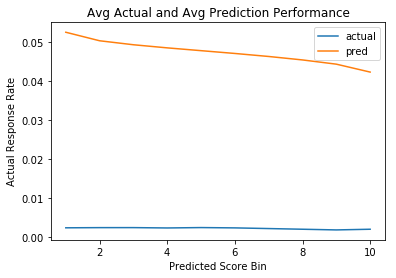

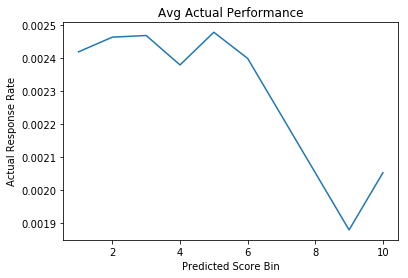

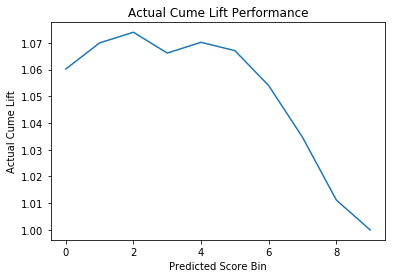

In [17]:

y_true=test[(test.Target_Net_Worth_20_881 >= 5) & (test.cell != 'E')].responder

test_score=test[(test.Target_Net_Worth_20_881 >= 5) & (test.cell != 'E')][keep_vars_linear].fillna(-999)

preds=mod_gs.best_estimator_.predict_proba(test_score)[:,1]
d=np.column_stack([y_true.values,preds]) 
eval_model_results_binary(d,10)

In [18]:
test.groupby(['cell','Target_Net_Worth_20_881']).size() 

cell  Target_Net_Worth_20_881
A     0                             886
      1                            3607
      2                            7697
      3                           12426
      4                           48627
      5                          119415
      6                          212552
      7                          103987
      8                           43531
      9                           24819
B     0                             898
      1                            3566
      2                            7649
      3                           12531
      4                           48341
      5                          118970
      6                          212607
      7                          104878
      8                           43365
      9                           24880
C     0                             888
      1                            3675
      2                            7616
      3                           12513
      4   

In [19]:
jan_bal_model=pd.read_csv('/user-home/1014/checking_models/score/scored.csv')
full_jan = full[(full.CAMPAIGN == 'JAN18')]
#del full

def resp_decile_classify(x): 
    if x >= 0.02016828: 
        resp_decile_range=1 
    elif x >=0.0183238479987624 and x < 0.02016828:
        resp_decile_range=2
    elif x >=0.0171368020008659 and x < 0.0183238479987624:
        resp_decile_range=3
    elif x >=0.0162066398244529 and x < 0.0171368020008659 :
        resp_decile_range=4
    elif x >=0.0153569084145478 and x < 0.0162066398244529:
        resp_decile_range=5    
    elif x >=0.0145335720355378 and x < 0.0153569084145478:
        resp_decile_range=6
    elif x >=0.0136686706768234 and x < 0.0145335720355378:
        resp_decile_range=7
    elif x >=0.0126610871036991 and x < 0.0136686706768234:
        resp_decile_range=8
    elif x >=0.0111844466793064 and x < 0.0126610871036991:
        resp_decile_range=9
    elif x < 0.0111844466793064:
        resp_decile_range=10
    
    return(resp_decile_range)

full_jan['decile_range']=full_jan.pred.apply(resp_decile_classify) 
print(full_jan.shape)
full_jan=pd.merge(full_jan,jan_bal_model,how='inner',left_on=['Person_Seq_No_1_183'], right_on=['Person_Seq_No_1_183'])


In [20]:
full_jan

,Person_Seq_No_1_183,pred
0,000000004000000000201D,4.805364
1,00000000400000000023DE,4.942798
2,0000000040000000004187,5.868667
3,0000000040000000007217,3.591807
4,00000000400000000082D9,5.264138


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 40.8min finished


{'depth': 7, 'learning_rate': 0.01}
AUC is: 0.570092440647
KS: 0.11658931989
Total Responders: 566.0
Lift Bin 1 (Vs Mean): 1.32509499361
Lift Bin 1 (Vs Last Bin): 2.20599312893


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,19913,75,0.003766,0.078574,1.325095,19913,75,0.003766,1.325095,0.076965,0.090197
1,2,19913,69,0.003465,0.076095,1.219087,39826,144,0.003616,1.272091,0.075334,0.076965
2,3,19913,68,0.003415,0.074678,1.201419,59739,212,0.003549,1.248534,0.074049,0.075334
3,4,19913,64,0.003214,0.073440,1.130748,79652,276,0.003465,1.219087,0.072836,0.074049
4,5,19913,51,0.002561,0.072216,0.901065,99565,327,0.003284,1.155483,0.071585,0.072836
5,6,19913,71,0.003566,0.070915,1.254423,119478,398,0.003331,1.171973,0.070222,0.071584
6,7,19913,64,0.003214,0.069467,1.130748,139391,462,0.003314,1.166084,0.068656,0.070222
7,8,19913,36,0.001808,0.067736,0.636046,159304,498,0.003126,1.099829,0.066730,0.068656
8,9,19913,34,0.001707,0.065532,0.600710,179217,532,0.002968,1.044371,0.064153,0.066730
9,10,19914,34,0.001707,0.061799,0.600680,199131,566,0.002842,1.000000,0.051688,0.064153


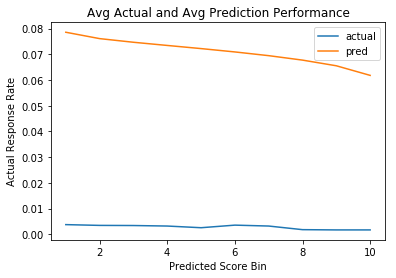

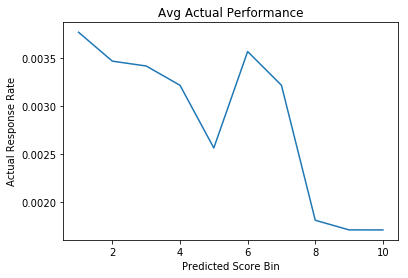

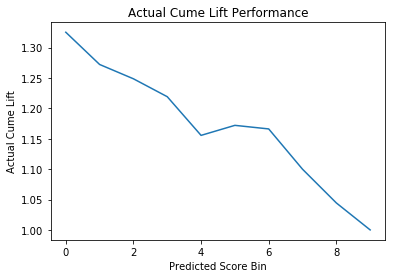

In [34]:
param_grid = {
'depth': [5,7,9],'learning_rate':[0.01]
}



fit_dict = {"eval_set":(x_dev2, y_dev), "use_best_model":True}
      
#small grid search for the best params
clf_cat=CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.05, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod_gs=GridSearchCV(clf_cat,param_grid=param_grid , n_jobs=1, cv=3,scoring='roc_auc',verbose=True )
mod_gs.fit(X=x_train2_HNW, y=y_train2_HNW.values.ravel(),**fit_dict)

#the final model fit (best params) will also employ early stopping
print(mod_gs.best_params_)

preds=mod_gs.best_estimator_.predict_proba(x_dev2)[:,1]
d=np.column_stack([y_dev.values,preds]) #out of fold
eval_model_results_binary(d,10)

In [155]:
pd.DataFrame(zip(mod_gs.best_estimator_.feature_importances_, x_train2_HNW.columns),columns=['rank','var']).sort_values('rank', ascending=False)



,rank,var
34,6.189944,Merit_Score_1881
3,5.720863,distance
6,4.647443,Target_PreMover_20_Model_879
2,4.601403,Advantage_Target_Income_20_876
20,4.441637,DMA_528
1,4.309626,Target_Home_Market_Value_894_v
42,4.208298,peraddress_bc
8,4.078420,MDM_hsld_ShrNEW24CHK24
31,3.813485,DMA_571
4,3.563667,MDM_household_Share_BG_ixi


In [ ]:
mod=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=14, 
              max_depth=-1, 
              learning_rate=0.1, 
              n_estimators=75, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=20, 
              subsample=1.0, 
              subsample_freq=1, 
              colsample_bytree=1.0, 
              reg_alpha=0.0, 
              reg_lambda=0.0, 
              random_state=4528, 
              n_jobs=1, 
              silent=True)
'''
param_grid = {
'learning_rate': [0.01, 0.05, 0.1],
'num_leaves': [10,15, 25, 50],
    'min_child_samples': [5, 10, 20],
    'reg_lambda' :[0.0, 0.001]
}

'''

#gbm = GridSearchCV(mod, param_grid, refit=True,verbose=5,cv=3,scoring='roc_auc',n_jobs=-1)


#customer scorer
lift_score=make_scorer(lift_decile_x_scorer,greater_is_better=True, needs_proba=True)


# specify parameters and distributions to sample from
param_dist = {'learning_rate': uniform(0.01,0.29),
              'num_leaves': sp_randint(10, 50),
              'min_child_samples': sp_randint(2, 30),
              'reg_lambda': uniform(0.0,0.01),
              'subsample': uniform(0.75,0.25), 
               'colsample_bytree':uniform(0.2,0.8), 
             
             }

# run randomized search
n_iter_search = 400
gbm= RandomizedSearchCV(mod, param_distributions=param_dist,n_jobs=-1,\
                        refit=True, cv=3,\
                        n_iter=n_iter_search,verbose=5,scoring=lift_score)




gbm.fit(x_train2, y_train2.values.ravel())
print('Best parameters found by grid search are:', gbm.best_params_)


preds=gbm.predict_proba(x_dev2)
d=np.column_stack([y_dev.values,preds[:,1]]) #out of fold
eval_model_results_binary(d,10)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 45.8min finished


{'depth': 9, 'learning_rate': 0.01}
AUC is: 0.584443550318
KS: 0.126511011561
Total Responders: 566.0
Lift Bin 1 (Vs Mean): 1.48410639284
Lift Bin 1 (Vs Last Bin): 2.54558237424


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,19913,84,0.004218,0.117312,1.484106,19913,84,0.004218,1.484106,0.105404,0.430446
1,2,19913,81,0.004068,0.100341,1.431103,39826,165,0.004143,1.457604,0.096209,0.105404
2,3,19913,68,0.003415,0.093063,1.201419,59739,233,0.003900,1.372209,0.090200,0.096208
3,4,19913,62,0.003114,0.087699,1.095412,79652,295,0.003704,1.303010,0.085345,0.090200
4,5,19913,57,0.002862,0.083119,1.007072,99565,352,0.003535,1.243823,0.080967,0.085345
5,6,19913,59,0.002963,0.078852,1.042408,119478,411,0.003440,1.210253,0.076752,0.080967
6,7,19913,42,0.002109,0.074648,0.742053,139391,453,0.003250,1.143368,0.072511,0.076752
7,8,19913,38,0.001908,0.070200,0.671381,159304,491,0.003082,1.084369,0.067797,0.072511
8,9,19913,42,0.002109,0.065037,0.742053,179217,533,0.002974,1.046334,0.062062,0.067797
9,10,19914,33,0.001657,0.057237,0.583013,199131,566,0.002842,1.000000,0.038298,0.062062


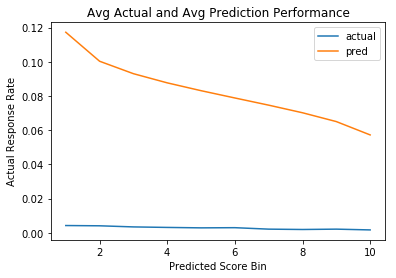

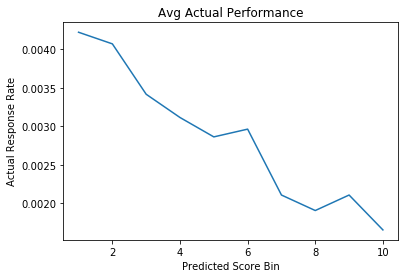

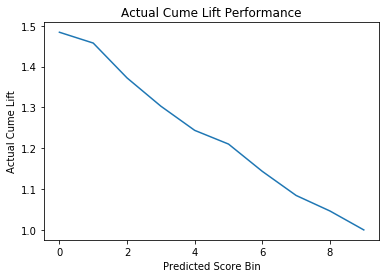

In [8]:
#use the val as early stopping CATBOOST

x_train2=x_train2.fillna(-999)
x_dev2=x_dev2.fillna(-999)


param_grid = {
'depth': [5,7,9],'learning_rate':[0.01]
}



fit_dict = {"eval_set":(x_dev2, y_dev), "use_best_model":True}
      
#small grid search for the best params
clf_cat=CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.05, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod_gs=GridSearchCV(clf_cat,param_grid=param_grid , n_jobs=1, cv=3,scoring='roc_auc',verbose=True )
mod_gs.fit(X=x_train2, y=y_train2.values.ravel(),**fit_dict)

#the final model fit (best params) will also employ early stopping
print(mod_gs.best_params_)

preds=mod_gs.best_estimator_.predict_proba(x_dev2)[:,1]
d=np.column_stack([y_dev.values,preds]) #out of fold
eval_model_results_binary(d,10)

AUC is: 0.571662392805
KS: 0.0992218641963
Total Responders: 679.0
Lift Bin 1 (Vs Mean): 1.53165844787
Lift Bin 1 (Vs Last Bin): 2.31111111111


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,26572,104,0.003914,0.122288,1.531658,26572,104,0.003914,1.531658,0.110796,0.449985
1,2,26572,99,0.003726,0.105743,1.458021,53144,203,0.003820,1.494840,0.101573,0.110796
2,3,26572,67,0.002521,0.098313,0.986742,79716,270,0.003387,1.325474,0.095305,0.101573
3,4,26572,62,0.002333,0.092695,0.913104,106288,332,0.003124,1.222381,0.090239,0.095305
4,5,26571,70,0.002634,0.087985,1.030963,132859,402,0.003026,1.184099,0.085824,0.090239
5,6,26572,67,0.002521,0.083759,0.986742,159431,469,0.002942,1.151206,0.081718,0.085823
6,7,26572,60,0.002258,0.079732,0.883649,186003,529,0.002844,1.112983,0.077772,0.081718
7,8,26572,56,0.002107,0.075728,0.824739,212575,585,0.002752,1.076952,0.073620,0.077772
8,9,26572,49,0.001844,0.071177,0.721647,239147,634,0.002651,1.037474,0.068468,0.073620
9,10,26572,45,0.001694,0.063567,0.662737,265719,679,0.002555,1.000000,0.040604,0.068468


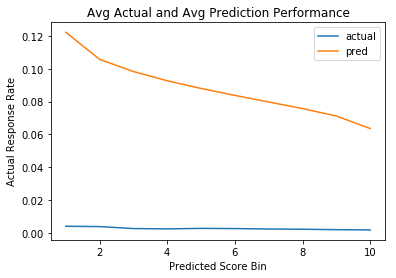

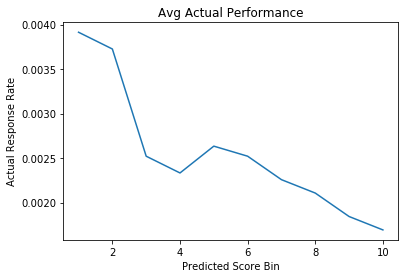

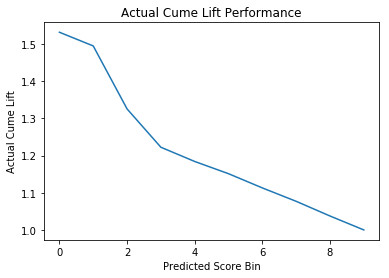

In [10]:
preds=mod_gs.best_estimator_.predict_proba(x_test)[:,1]
d=np.column_stack([y_test.values,preds]) #out of fold
eval_model_results_binary(d,10)

AUC is: 0.5644891126
KS: 0.0981909363613
Total Responders: 679.0
Lift Bin 1 (Vs Mean): 1.32547365681
Lift Bin 1 (Vs Last Bin): 1.91489361702


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,26572,90,0.003387,0.023310,1.325474,26572,90,0.003387,1.325474,0.020143,0.048069
1,2,26572,89,0.003349,0.019337,1.310746,53144,179,0.003368,1.318110,0.018672,0.020143
2,3,26572,81,0.003048,0.018161,1.192926,79716,260,0.003262,1.276382,0.017670,0.018672
3,4,26572,71,0.002672,0.017197,1.045651,106288,331,0.003114,1.218699,0.016742,0.017670
4,5,26571,75,0.002823,0.016323,1.104603,132859,406,0.003056,1.195881,0.015910,0.016742
5,6,26572,65,0.002446,0.015505,0.957287,159431,471,0.002954,1.156115,0.015096,0.015910
6,7,26572,57,0.002145,0.014681,0.839467,186003,528,0.002839,1.110879,0.014258,0.015096
7,8,26572,58,0.002183,0.013766,0.854194,212575,586,0.002757,1.078793,0.013206,0.014258
8,9,26572,46,0.001731,0.012457,0.677464,239147,632,0.002643,1.034201,0.011611,0.013206
9,10,26572,47,0.001769,0.010558,0.692192,265719,679,0.002555,1.000000,0.006742,0.011611


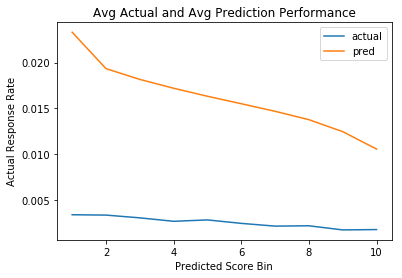

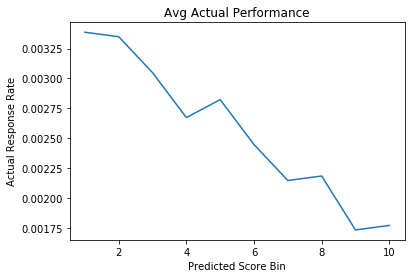

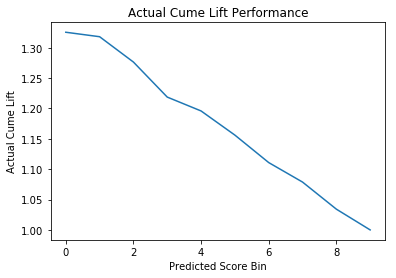

In [11]:

x_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_test.csv')
y_test =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_test.csv')
x_test['MDM_household_Share_BG_ixi']=x_test['MDM_household_Share_BG'] / x_test['total']
x_test['PEN_CHECK']=x_test['SUM_CHECKING_IND_BG'] / x_test['total_ixi_check_custs']
x_test['peraddress_53']=x_test['sum_fifth_third'] / x_test['addresses_CT']
x_test['peraddress_bc']=x_test['total_bankingcenters'] / x_test['addresses_CT']

#x_test=x_test.drop(['pred','campaign','block_group','Advantage_Individual_Age_1_262'],axis=1)

d=np.column_stack([y_test.values,x_test.pred.values]) #out of fold
eval_model_results_binary(d,10)

In [ ]:
#optimize on the dev sample only

combine_dataX=pd.concat([x_train2,x_dev2], axis=0)
combine_datay=pd.concat([y_train2,y_dev], axis=0)



mod=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=14, 
              max_depth=-1, 
              learning_rate=0.1, 
              n_estimators=75, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=20, 
              subsample=1.0, 
              subsample_freq=1, 
              colsample_bytree=1.0, 
              reg_alpha=0.0, 
              reg_lambda=0.0, 
              random_state=4528, 
              n_jobs=1, 
              silent=True)


#customer scorer
lift_score=make_scorer(lift_decile_x_scorer,greater_is_better=True, needs_proba=True)


# specify parameters and distributions to sample from
param_dist = {'learning_rate': uniform(0.01,0.29),
              'num_leaves': sp_randint(10, 50),
              'min_child_samples': sp_randint(2, 30),
              'reg_lambda': uniform(0.0,0.01),
              'subsample': uniform(0.75,0.25), 
               'colsample_bytree':uniform(0.2,0.8), 
               'n_estimators':sp_randint(10, 100) 
             
             }



#validation split for 1 fold cv
val0=np.array([0 for x in range(x_train2.shape[0])])
val_1=np.array([-1 for x in range(x_dev2.shape[0])])
val=np.append(val0,val_1,axis=0)
validation_split=list(PredefinedSplit(val).split())


# run randomized search
n_iter_search = 500
gbm= RandomizedSearchCV(mod, param_distributions=param_dist,n_jobs=5,\
                        refit=False, #else refits on the entire combined data\ 
                        cv=validation_split,\
                        n_iter=n_iter_search,verbose=5,\
                        scoring='roc_auc')




gbm.fit(combine_dataX, combine_datay.values.ravel())
print('Best parameters found by grid search are:', gbm.best_params_)
print('Best score:', gbm.best_score_)

#preds=gbm.predict_proba(x_dev2)
#d=np.column_stack([y_dev.values,preds[:,1]]) #out of fold
#eval_model_results_binary(d,10)




Fitting 1 folds for each of 500 candidates, totalling 500 fits
[CV] num_leaves=48, colsample_bytree=0.6967223313168818, learning_rate=0.06723718606450886, n_estimators=18, subsample=0.8662356018669699, reg_lambda=0.007829591972880329, min_child_samples=26 
[CV] num_leaves=23, colsample_bytree=0.512156467727785, learning_rate=0.29643041110453044, n_estimators=28, subsample=0.7734927377398879, reg_lambda=0.003850990613635109, min_child_samples=22 
[CV] num_leaves=14, colsample_bytree=0.9032895848460483, learning_rate=0.1547305319879969, n_estimators=32, subsample=0.8039824787690208, reg_lambda=0.005554311217048941, min_child_samples=3 
[CV] num_leaves=27, colsample_bytree=0.8692746660632855, learning_rate=0.011650766816955671, n_estimators=90, subsample=0.8852424488280144, reg_lambda=0.0014475236275161307, min_child_samples=24 
[CV] num_leaves=43, colsample_bytree=0.6304611650310548, learning_rate=0.015769940779833277, n_estimators=52, subsample=0.9561299601115663, reg_lambda=0.006817768

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  2.7min


[CV]  num_leaves=25, colsample_bytree=0.6122512462321681, learning_rate=0.23190028788331954, n_estimators=12, subsample=0.944717818291811, reg_lambda=0.0019870940880111886, min_child_samples=22, score=0.560534377573, total=  42.9s
[CV] num_leaves=14, colsample_bytree=0.8845770718995265, learning_rate=0.16385195142549394, n_estimators=40, subsample=0.8556900075748274, reg_lambda=0.0028935454422022956, min_child_samples=13 
[CV]  num_leaves=10, colsample_bytree=0.30031034613537444, learning_rate=0.26911235854714166, n_estimators=79, subsample=0.8899692323865683, reg_lambda=0.005482821076057944, min_child_samples=29, score=0.53410305945, total= 1.2min
[CV] num_leaves=17, colsample_bytree=0.42008889702020186, learning_rate=0.27917760950962606, n_estimators=90, subsample=0.9173002336225679, reg_lambda=0.00911884168683318, min_child_samples=10 
[CV]  num_leaves=31, colsample_bytree=0.8335988004509238, learning_rate=0.03677495493746021, n_estimators=55, subsample=0.7930903723865511, reg_lambd

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed: 15.9min


[CV]  num_leaves=41, colsample_bytree=0.3800253056838194, learning_rate=0.08163247130523225, n_estimators=32, subsample=0.7815313999512984, reg_lambda=0.006887461357496173, min_child_samples=23, score=0.548355371202, total=  58.7s
[CV] num_leaves=47, colsample_bytree=0.5488874949677682, learning_rate=0.25116532789887996, n_estimators=23, subsample=0.8836480577778929, reg_lambda=0.009283349729393923, min_child_samples=26 
[CV]  num_leaves=47, colsample_bytree=0.7137522688561233, learning_rate=0.018500872400248367, n_estimators=14, subsample=0.899156879005943, reg_lambda=0.004496614870051556, min_child_samples=11, score=0.556876036241, total=  45.8s
[CV] num_leaves=43, colsample_bytree=0.4425218177851906, learning_rate=0.02172165498138215, n_estimators=34, subsample=0.809247960720466, reg_lambda=0.0018032405561508136, min_child_samples=11 
[CV]  num_leaves=17, colsample_bytree=0.34833146369562773, learning_rate=0.19829089543431602, n_estimators=67, subsample=0.9471852357630066, reg_lambd

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 39.6min


[CV]  num_leaves=18, colsample_bytree=0.9623268677055539, learning_rate=0.21416027969655754, n_estimators=39, subsample=0.9748247612064648, reg_lambda=0.00862430749158111, min_child_samples=19, score=0.542946915235, total= 1.1min
[CV] num_leaves=15, colsample_bytree=0.2099838924838797, learning_rate=0.09828517910934376, n_estimators=15, subsample=0.8466904367225992, reg_lambda=0.00907518790315235, min_child_samples=11 
[CV]  num_leaves=37, colsample_bytree=0.625000804917843, learning_rate=0.2704286892354418, n_estimators=11, subsample=0.8766933317791565, reg_lambda=0.001775356471991716, min_child_samples=8, score=0.555851084927, total=  45.8s
[CV] num_leaves=29, colsample_bytree=0.607308737693071, learning_rate=0.21151922473122553, n_estimators=36, subsample=0.760565477917538, reg_lambda=0.0005641457093411418, min_child_samples=27 
[CV]  num_leaves=35, colsample_bytree=0.31853956856760546, learning_rate=0.12803682733273086, n_estimators=35, subsample=0.855676855983162, reg_lambda=9.500

[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 74.1min


[CV]  num_leaves=49, colsample_bytree=0.7922871364580051, learning_rate=0.22082197805806975, n_estimators=64, subsample=0.9700391554988893, reg_lambda=0.008116853101525292, min_child_samples=16, score=0.567151582553, total= 1.9min
[CV] num_leaves=31, colsample_bytree=0.8481229362181071, learning_rate=0.20714655573109886, n_estimators=62, subsample=0.8253093079817384, reg_lambda=0.0041465494606305105, min_child_samples=26 
[CV]  num_leaves=17, colsample_bytree=0.9731830390500364, learning_rate=0.03959257997483124, n_estimators=87, subsample=0.997223861316786, reg_lambda=0.002433559140048088, min_child_samples=24, score=0.559972545701, total= 1.7min
[CV] num_leaves=31, colsample_bytree=0.8139955695836556, learning_rate=0.0880164803234857, n_estimators=37, subsample=0.8784484379507658, reg_lambda=0.005264190040980782, min_child_samples=15 
[CV]  num_leaves=10, colsample_bytree=0.6492708216778438, learning_rate=0.07229092805936635, n_estimators=28, subsample=0.985686955036366, reg_lambda=0

In [ ]:
('Best parameters found by grid search are:', {'num_leaves': 39, 'colsample_bytree': 0.31406886129341083, 'learning_rate': 0.1854918321154109, 'subsample': 0.8752413928905266, 'reg_lambda': 0.00929937954049252, 'min_child_samples': 5})
('Best score:', 0.5805659195104965)

('Best parameters found by grid search are:', {'num_leaves': 26, 'colsample_bytree': 0.5960096136042505, 'learning_rate': 0.19686712891929026, 'subsample': 0.7861590947482204, 'reg_lambda': 0.0011406055133676575, 'min_child_samples': 6})
('Best score:', 0.6143547890284526)

AUC is: 0.580844520566
KS: 0.125801779713
Total Responders: 566.0
Lift Bin 1 (Vs Mean): 1.46651210556
Lift Bin 1 (Vs Last Bin): 2.4414216671


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,19912,83,0.004168,0.138019,1.466512,19912,83,0.004168,1.466512,0.118438,0.448680
1,2,19914,73,0.003666,0.112784,1.289694,39826,156,0.003917,1.378099,0.108233,0.118437
2,3,19913,70,0.003515,0.104791,1.236755,59739,226,0.003783,1.330984,0.101641,0.108233
3,4,19913,68,0.003415,0.098751,1.201419,79652,294,0.003691,1.298593,0.095981,0.101640
4,5,19913,60,0.003013,0.093451,1.060076,99565,354,0.003555,1.250890,0.090986,0.095981
5,6,19913,55,0.002762,0.088566,0.971736,119478,409,0.003423,1.204364,0.086134,0.090986
6,7,19913,45,0.002260,0.083623,0.795057,139391,454,0.003257,1.145892,0.081065,0.086134
7,8,19913,42,0.002109,0.078201,0.742053,159304,496,0.003114,1.095412,0.075067,0.081065
8,9,19913,36,0.001808,0.070800,0.636046,179217,532,0.002968,1.044371,0.065817,0.075067
9,10,19914,34,0.001707,0.060778,0.600680,199131,566,0.002842,1.000000,0.050969,0.065817


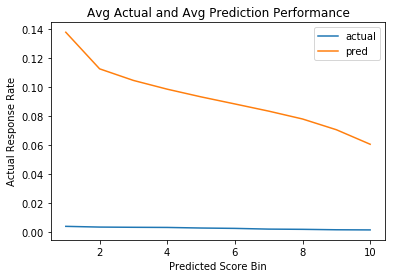

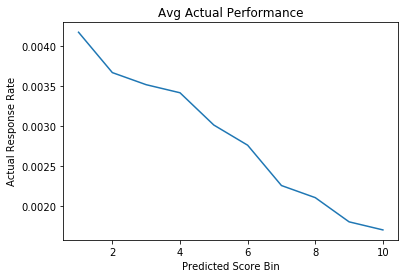

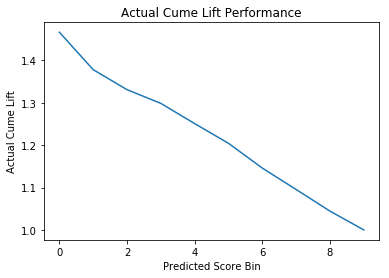

In [4]:
('Best parameters found by grid search are:', {'num_leaves': 25, 'learning_rate': 0.05, 'min_child_samples': 10})

mod=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=26, 
              max_depth=-1, 
              learning_rate=0.19686712891929026, 
              n_estimators=75, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=6, 
              subsample=0.7861590947482204, 
              subsample_freq=1, 
              colsample_bytree=0.5960096136042505, 
              reg_alpha=0.0, 
              reg_lambda=0.0011406055133676575, 
              random_state=4528, 
              n_jobs=1, 
              silent=True)



mod=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=25, 
              max_depth=-1, 
              learning_rate=0.05, 
              n_estimators=75, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=10, 
              subsample=1.0, 
              subsample_freq=1, 
              colsample_bytree=1.0, 
              reg_alpha=0.0, 
              reg_lambda=0.0, 
              random_state=4528, 
              n_jobs=1, 
              silent=True)

mod.fit(x_train2,y_train2.values.ravel())
preds=mod.predict_proba(x_dev2)[:,1]
d=np.column_stack([y_dev.values,preds]) 
eval_model_results_binary(d,10)

AUC is: 0.569036843634
KS: 0.100856985713
Total Responders: 679.0
Lift Bin 1 (Vs Mean): 1.39921639729
Lift Bin 1 (Vs Last Bin): 2.15949721148


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,26570,95,0.003575,0.137990,1.399216,26570,95,0.003575,1.399216,0.118529,0.448680
1,2,26574,101,0.003801,0.112898,1.487364,53144,196,0.003688,1.443294,0.108341,0.118529
2,3,26569,76,0.002860,0.104932,1.119415,79713,272,0.003412,1.335342,0.101781,0.108341
3,4,26575,61,0.002295,0.098963,0.898275,106288,333,0.003133,1.226063,0.096236,0.101780
4,5,26571,64,0.002409,0.093711,0.942595,132859,397,0.002988,1.169371,0.091247,0.096235
5,6,26572,65,0.002446,0.088834,0.957287,159431,462,0.002898,1.134023,0.086415,0.091247
6,7,26572,69,0.002597,0.083932,1.016196,186003,531,0.002855,1.117191,0.081365,0.086415
7,8,26572,57,0.002145,0.078496,0.839467,212575,588,0.002766,1.082475,0.075392,0.081364
8,9,26569,47,0.001769,0.071108,0.692270,239144,635,0.002655,1.039123,0.066186,0.075392
9,10,26575,44,0.001656,0.060923,0.647936,265719,679,0.002555,1.000000,0.050980,0.066186


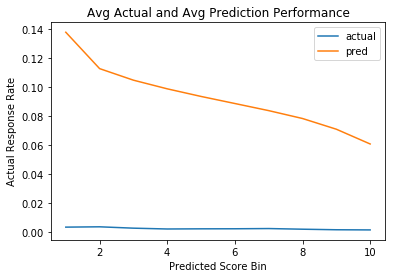

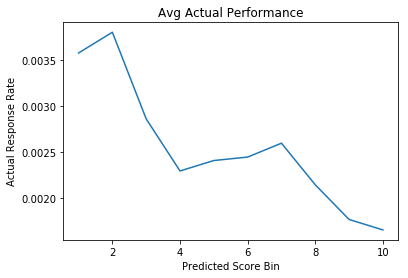

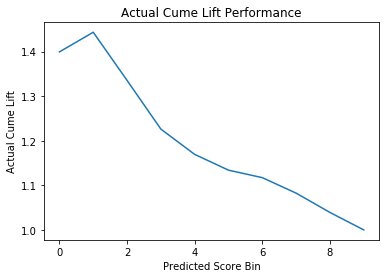

In [10]:
preds=mod.predict_proba(x_test)[:,1]
d=np.column_stack([y_test.values,preds]) 
eval_model_results_binary(d,10)

In [ ]:
d=np.column_stack([y_dev.values,x_dev.pred.values]) 
eval_model_results_binary(d,10)

In [ ]:
lift_decile_x_scorer(y_dev.values.flatten(),x_dev.pred.values,1)


In [ ]:
def lift_decile_x_scorer (y_true, y_pred, lift_decile=1, proba=True):
    
    #requires:
    import pandas as pd
    import numpy as np
    
    
    if proba:
        y_pred=y_pred[:,1]
    
   #calculate gains / lift
    bins=10
    try:
        result=pd.DataFrame(pd.DataFrame({'actual':y_true,'pred':y_pred}))
        result['decile']=(bins)-(pd.qcut(result.pred,bins,labels=False))
        grp_dec=result.groupby('decile')
        mean_act_pred=grp_dec['actual'].mean()
        overall= y_true.mean() 
        return(mean_act_pred.iloc[lift_decile-1]/overall)
    except Exception , e:
        print (e)
        return(0)

In [ ]:
x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')
x_train['MDM_household_Share_BG_ixi']=x_train['MDM_household_Share_BG'] / x_train['total']
x_train['PEN_CHECK']=x_train['SUM_CHECKING_IND'] / x_train['total_ixi_check_custs']
x_train['peraddress_53']=x_train['sum_fifth_third'] / x_train['addresses_CT']
x_train['peraddress_bc']=x_train['total_bankingcenters'] / x_train['addresses_CT']


<h3>Several attempts at improving over prior</h3>

In [ ]:
d=np.column_stack([y_train.values,x_train.pred]) 
eval_model_results_binary(d,10)

In [ ]:
# Model higher income################################################
#####################################################################

#load
x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')
x_train['MDM_household_Share_BG_ixi']=x_train['MDM_household_Share_BG'] / x_train['total']
x_train['PEN_CHECK']=x_train['SUM_CHECKING_IND_BG'] / x_train['total_ixi_check_custs']
x_train['peraddress_53']=x_train['sum_fifth_third'] / x_train['addresses_CT']
x_train['peraddress_bc']=x_train['total_bankingcenters'] / x_train['addresses_CT']


#create county
v=x_train.census_tract.astype('str')
x_train['county']=v.apply(lambda x : x[0:5])

#drop variables we dont want
x_train=x_train.drop(['block_group','census_tract', 'pred',
'DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560',
'TNW_TL',
'DMA_TL',
'preMover_TL',
'SFC_TL',
'county_TL' ],axis=1)

#plug missing in cats
x_train['county']=x_train['county'].fillna('-99')
x_train['DMA_176']=x_train['DMA_176'].fillna(-99)
x_train['collapsed_niche_indx']=x_train['collapsed_niche_indx'].fillna(-99)

###################Limit based on net worth##################################################
high_indx=x_train.Target_Net_Worth_20_881 >=5
x_train=x_train[high_indx]
y_train=y_train[high_indx]
############################################################################################

#variables from march for linear model
keep_vars_linear=['MDM_hsld_ShrNEW24',
'Target_Home_Market_Value_894_v',
'Advantage_Target_Income_20_876',
'distance',
'MDM_household_Share_BG_ixi',
'MDM_CKBAL_ShareIXI_BG',
'Target_PreMover_20_Model_879',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_hsld_ShrNEW24CHK24',
'prop_MM',
'Advantage_Length_of_Residen_823',
#'DMA_176',
'new_hhs_24',
'PEN_CHECK'
]





#model instances
lr=LogisticRegressionCV()

#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],4))

#define folds
kf = KFold(n_splits=10,random_state=4528996)
counter =1

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    
    #linear model with a couple variables we understood from before are linearly related to the target
    X_train_l=X_train[keep_vars_linear].fillna(X_train[keep_vars_linear].mean())
    lr.fit(X_train_l.values,Y_train.ravel())
    pred_lr=lr.predict_proba(X_train_l.values)[:,1]
    
    print("lr")
    #calculate residual and make this the target for trees
    resid=Y_train.ravel()#-pred_lr
    
    ###################################
    #fit model to residuals############
    ###################################
    
    #first sample out dev for early stopping
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, resid, test_size=0.20, random_state=42)
    
    #early stopping
    boostreg=CatBoostRegressor(iterations=1500, depth=5, learning_rate=0.1, loss_function='RMSE',nan_mode='Min',random_seed=42,od_type = "Iter",  od_wait = 20)
    boostreg.fit(X=X_train2, y=y_train2, eval_set =(X_test2, y_test2),use_best_model=True,cat_features=[0,29,813])
    
    #refit
    boostreg=CatBoostRegressor(iterations=boostreg.tree_count_, depth=5, learning_rate=0.1, loss_function='RMSE',nan_mode='Min',random_seed=42)
    boostreg.fit(X_train.values,resid,cat_features=[0,29,813])
    
    pred_boost=boostreg.predict(X_train.values)
    pred_train=pred_lr+pred_boost
    print("boost")
    
    
    
    
    
    
    
    #predicted both models on oof
    X_test_l=X_test[keep_vars_linear].fillna(X_test[keep_vars_linear].mean())
    pred_lr_oof=lr.predict_proba(X_test_l.values)[:,1]
    pred_boost_oof=boostreg.predict(X_test.values)
    pred_test = pred_lr_oof+pred_boost_oof
    print("preds")
    
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)

In [ ]:
# Model higher income################################################
#####################################################################

#WITHOUT USING CATEGORIALS

#load
x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')
x_train['MDM_household_Share_BG_ixi']=x_train['MDM_household_Share_BG'] / x_train['total']
x_train['PEN_CHECK']=x_train['SUM_CHECKING_IND'] / x_train['total_ixi_check_custs']
x_train['peraddress_53']=x_train['sum_fifth_third'] / x_train['addresses_CT']
x_train['peraddress_bc']=x_train['total_bankingcenters'] / x_train['addresses_CT']




#drop variables we dont want
x_train=x_train.drop(['block_group','census_tract', 'pred',
'DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560'#,
#'TNW_TL',
#'DMA_TL',
#'preMover_TL',
#'SFC_TL',
#'county_TL'
],axis=1)

#plug missing in cats
x_train['DMA_176']=x_train['DMA_176'].fillna(-99)
x_train['collapsed_niche_indx']=x_train['collapsed_niche_indx'].fillna(-99)

###################Limit based on net worth##################################################
high_indx=x_train.Target_Net_Worth_20_881 >=5
x_train=x_train[high_indx]
y_train=y_train[high_indx]
############################################################################################

#variables from march for linear model
keep_vars_linear=['MDM_hsld_ShrNEW24',
'Target_Home_Market_Value_894_v',
'Advantage_Target_Income_20_876',
'distance',
'MDM_household_Share_BG_ixi',
'MDM_CKBAL_ShareIXI_BG',
'Target_PreMover_20_Model_879',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_hsld_ShrNEW24CHK24',
'prop_MM',
'Advantage_Length_of_Residen_823'
]





#model instances
lr=LogisticRegressionCV()

#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],4))

#define folds
kf = KFold(n_splits=10,random_state=4528996)
counter =1

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    
    #linear model with a couple variables we understood from before are linearly related to the target
    X_train_l=X_train[keep_vars_linear].fillna(X_train[keep_vars_linear].mean())
    lr.fit(X_train_l.values,Y_train.ravel())
    pred_lr=lr.predict_proba(X_train_l.values)[:,1]
    
    print("lr")
    #calculate residual and make this the target for trees
    resid=Y_train.ravel()#-pred_lr
    
    ###################################
    #fit model to residuals############
    ###################################
    
    #first sample out dev for early stopping
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, resid, test_size=0.20, random_state=42)
    
    #early stopping
    boostreg=CatBoostRegressor(iterations=1500, depth=5, learning_rate=0.1, loss_function='RMSE',nan_mode='Min',random_seed=42,od_type = "Iter",  od_wait = 20)
    boostreg.fit(X=X_train2, y=y_train2, eval_set =(X_test2, y_test2),use_best_model=True)
    
    #refit
    boostreg=CatBoostRegressor(iterations=boostreg.tree_count_, depth=5, learning_rate=0.1, loss_function='RMSE',nan_mode='Min',random_seed=42)
    boostreg.fit(X_train.values,resid)
    
    pred_boost=boostreg.predict(X_train.values)
    pred_train=pred_lr+pred_boost
    print("boost")
    
    
    
    
    
    
    
    #predicted both models on oof
    X_test_l=X_test[keep_vars_linear].fillna(X_test[keep_vars_linear].mean())
    pred_lr_oof=lr.predict_proba(X_test_l.values)[:,1]
    pred_boost_oof=boostreg.predict(X_test.values)
    pred_test = pred_lr_oof+pred_boost_oof
    print("preds")
    
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)

In [ ]:
#experiment with single model

# Model higher income################################################
#####################################################################

#WITHOUT USING CATEGORIALS

#load
x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')
x_train['MDM_household_Share_BG_ixi']=x_train['MDM_household_Share_BG'] / x_train['total']
x_train['PEN_CHECK']=x_train['SUM_CHECKING_IND'] / x_train['total_ixi_check_custs']
x_train['peraddress_53']=x_train['sum_fifth_third'] / x_train['addresses_CT']
x_train['peraddress_bc']=x_train['total_bankingcenters'] / x_train['addresses_CT']




#drop variables we dont want
x_train=x_train.drop(['block_group','census_tract', 'pred',
'DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560'#,
#'TNW_TL',
#'DMA_TL',
#'preMover_TL',
#'SFC_TL',
#'county_TL'
],axis=1)

#plug missing in cats
x_train['DMA_176']=x_train['DMA_176'].fillna(-99)
x_train['collapsed_niche_indx']=x_train['collapsed_niche_indx'].fillna(-99)

###################Limit based on net worth##################################################
high_indx=x_train.Target_Net_Worth_20_881 >=5
x_train=x_train[high_indx]
y_train=y_train[high_indx]
############################################################################################

#variables from march for linear model
keep_vars_linear=['MDM_hsld_ShrNEW24',
'Target_Home_Market_Value_894_v',
'Advantage_Target_Income_20_876',
'distance',
'MDM_household_Share_BG_ixi',
'MDM_CKBAL_ShareIXI_BG',
'Target_PreMover_20_Model_879',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_hsld_ShrNEW24CHK24',
'prop_MM',
'Advantage_Length_of_Residen_823'
]



x_train=x_train.fillna(-99)


#model instances
rf=LogisticRegressionCV()
#rf=RandomForestClassifier()
#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],4))

#define folds
kf = KFold(n_splits=10,random_state=4528996)
counter =1

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    
    #linear model with a couple variables we understood from before are linearly related to the target
    X_train_l=X_train[keep_vars_linear]
    rf.fit(X_train_l.values,Y_train.ravel())
    pred_train=rf.predict_proba(X_train_l.values)[:,1]
    
    X_test_l=X_test[keep_vars_linear]
    pred_test=rf.predict_proba(X_test_l.values)[:,1]
    
    
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)


In [ ]:
#cluster blockgroups

x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')

x_train['MDM_household_Share_BG_ixi']=x_train['MDM_household_Share_BG'] / x_train['total']
x_train['PEN_CHECK']=x_train['SUM_CHECKING_IND_BG'] / x_train['total_ixi_check_custs']
x_train['peraddress_53']=x_train['sum_fifth_third'] / x_train['addresses_CT']
x_train['peraddress_bc']=x_train['total_bankingcenters'] / x_train['addresses_CT']


vars_keep_cluster=['addresses_BG','MDM_CKBAL_ShareIXI_BG','MDM_CKhousehold_ShareFE_BG',
                   'MDM_CKhousehold_ShareMA_BG','MDM_CKhousehold_ShareMM_BG','MDM_CKhousehold_ShareUB_BG',
                   'MDM_CKhousehold_Share_BG','MDM_household_Share_BG',
                   'BG_prop_12_new_hh_with_check',
                   'BG_prop_all_check_12mon',
                   'meanC_CONS_DEPOSIT_BAL_AMT_BG']

x_train=x_train[vars_keep_cluster]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

x_train2=x_train.fillna(x_train.mean())
ss=StandardScaler()
x_train2ss=ss.fit_transform(x_train2.values)

kmeans = KMeans(n_clusters=20, random_state=0).fit(x_train2ss)


#x_train2=pd.DataFrame(ss.inverse_transform(x_train2ss),columns=[vars_keep_cluster])
x_train2['cluster_label']=pd.Series(kmeans.labels_)
x_train2.head()
x_train2['response']=y_train.values
x_train2.head()

response=x_train2.groupby('cluster_label')['response'].agg(['count','mean'])
response=response.reset_index()

clusters=pd.DataFrame(kmeans.cluster_centers_, columns=[vars_keep_cluster])



clusters['count']=response['count']
clusters['rr']=response['mean']
clusters

In [ ]:
# Model higher income################################################
#####################################################################

#load
x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')
x_train['MDM_household_Share_BG_ixi']=x_train['MDM_household_Share_BG'] / x_train['total']
x_train['PEN_CHECK']=x_train['SUM_CHECKING_IND'] / x_train['total_ixi_check_custs']
x_train['peraddress_53']=x_train['sum_fifth_third'] / x_train['addresses_CT']
x_train['peraddress_bc']=x_train['total_bankingcenters'] / x_train['addresses_CT']


#create county
v=x_train.census_tract.astype('str')
x_train['county']=v.apply(lambda x : x[0:5])

#drop variables we dont want
x_train=x_train.drop(['block_group','census_tract', 'pred',
'DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560',
'TNW_TL',
'DMA_TL',
'preMover_TL',
'SFC_TL',
'county_TL' ],axis=1)

#plug missing in cats
x_train['county']=x_train['county'].fillna('-99')
x_train['DMA_176']=x_train['DMA_176'].fillna(-99)
x_train['collapsed_niche_indx']=x_train['collapsed_niche_indx'].fillna(-99)

###################Limit based on net worth##################################################
high_indx=x_train.Target_Net_Worth_20_881 >=5
x_train=x_train[high_indx]
y_train=y_train[high_indx]
############################################################################################

In [ ]:
#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],4))

#define folds
kf = KFold(n_splits=10,random_state=4528996)
counter =1

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    
    #first sample out dev for early stopping
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train.values, Y_train, test_size=0.20, random_state=42)
    
    #early stopping
    boostreg=CatBoostClassifier(iterations=1500, depth=5, learning_rate=0.1, loss_function='CrossEntropy',nan_mode='Min',random_seed=42,od_type = "Iter",  od_wait = 20)
    boostreg.fit(X=X_train2, y=y_train2.ravel(), eval_set =(X_test2, y_test2.ravel()),use_best_model=True,cat_features=[0,29,813])
    
    #refit
    boostreg=CatBoostClassifier(iterations=boostreg.tree_count_, depth=5, learning_rate=0.1, loss_function='CrossEntropy',nan_mode='Min',random_seed=42)
    boostreg.fit(X_train.values,Y_train.ravel(),cat_features=[0,29,813])
    
    pred_train=boostreg.predict_proba(X_train.values)[:,1]
    
    #predicted both models on oof
    pred_test=boostreg.predict_proba(X_test.values)[:,1]
    
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)

In [ ]:
x_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/X_train.csv')
y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')
high_indx=x_train.Target_Net_Worth_20_881 >=5
d=np.column_stack([y_train[high_indx].values,x_train[high_indx].pred]) 
eval_model_results_binary(d,10)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

selector = SelectKBest(mutual_info_classif,30,)
selector.fit(x_train.drop(['Person_Seq'],axis=1).fillna(0), y_train)

pd.DataFrame(zip(selector.scores_, x_train.drop(['Person_Seq'],axis=1).columns),columns=['rank','var']).sort_values('rank', ascending=False).to_csv('/user-home/1014/checking_models/response_rebuild/imp_train.csv', index=False)

In [ ]:
#FS using random forest
from sklearn.ensemble import GradientBoostingClassifier
rf=RandomForestClassifier(n_estimators=50, n_jobs=-1)
rf.fit(x_train.fillna(0), y_train)
pd.DataFrame(zip(rf.feature_importances_, x_train.columns),columns=['rank','var']).sort_values('rank', ascending=False).to_csv('/user-home/1014/checking_models/response_rebuild/rf_imp_train.csv', index=False)


In [ ]:
#predict dev
preds = rf.predict_proba (x_dev.fillna(0))
d=np.column_stack([y_dev.values,preds[:,1]])
eval_model_results_binary(d,10)

In [ ]:
oof_preds_dct1={'actual':[],'preds':[]}
params_xg = {'booster': 'gbtree','max_depth':5, 'eta':0.05, 'silent':1, 'objective':'binary:logistic','nthread':8}
dtrain_xg=xgb.DMatrix(x_train.values, label=y_train.values.ravel())
xgb.cv(params=params_xg,dtrain=dtrain_xg,num_boost_round=1500, early_stopping_rounds=10,folds=5,callbacks=[OOFCallback(oof_preds_dct=oof_preds_dct1,maximize=False)])

In [ ]:
d=np.column_stack([oof_preds_dct1['actual'],oof_preds_dct1['preds']])
eval_model_results_binary(d,5)

In [ ]:
#rfe

newx,newy=oversample_2class(x_train,y_train,0.05)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression()
selector = RFE(estimator, 50, step=1)
selector = selector.fit(newx.fillna(0), newy)
pd.DataFrame(zip(selector.ranking_, x_train.columns),columns=['rank','var']).sort_values('rank', ascending=False).to_csv('/user-home/1014/checking_models/response_rebuild/rfe_imp_train.csv', index=False)


In [ ]:
#use the over sample to run stacking on a smaller subset of variables from FS above
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

vars_use=['addresses_CT',
'Advantage_Home_Owner_813',
'Advantage_Individual_Age_1_262',
'Advantage_Length_of_Residen_823',
'Available_home_equity_in_th_899',
'avg_Fullservice_Branch_YesNo',
'CD_excludeIRA_AVG_VALUE',
'checking_AVGBAL_MA',
'checking_AVGBAL_MA_BG',
'checking_AVGBAL_MM',
'checking_AVGBAL_MM_BG',
'checking_BAL_MM_BG',
'collapsed_niche_indx',
'CONS_IND',
'CONS_IND_BG',
'Credit_Card_Trigger_978',
'Current_Loan_to_Value_890',
'Deposit_TOTAL',
'distance',
'DMA_176',
'FE_ixi_total_bals',
'Home_equity_loan_in_thousan_913',
'Home_Market_Value_Tax_Reco_918',
'Home_Market_Value_Trigger_1001',
'Income_Trigger_1009',
'InterDDA_AVG_VALUE',
'Investment_Resources_1091',
'ixi_total_bals_A01',
'ixi_total_bals_A03',
'ixi_total_bals_B07',
'ixi_total_bals_C09',
'ixi_total_bals_E18',
'ixi_total_bals_M46',
'ixi_total_bals_P55',
'Liquid_Resources_1093',
'MDM_CKhousehold_Share',
'MDM_household_Share_BG',
'MDM_household_Share_BG_ixi',
'MDM_hsld_ShrNEW24',
'meanC_ANNUITY_BAL_AMT',
'meanC_BUS_DEPOSIT_BAL_AMT_BG',
'meanC_CHECKING_BAL_AMT_BG',
'meanC_CONS_LOAN_BAL_AMT_BG',
'meanC_CREDIT_CARD_BAL_AMT',
'meanC_INSURANCE_BAL_AMT',
'meanC_INSURANCE_BAL_AMT_BG',
'meanC_MERCHANT_BAL_AMT',
'meanC_MERCHANT_BAL_AMT_BG',
'meanC_MORTGAGE_BAL_AMT',
'Merit_Score_1881',
'MM_Save_AVG_VALUE',
'MT_401k_Owners_1148',
'MT_Credit_Card_Balance_Tr_1254',
'MT_Credit_Card_Revolvers_1256',
'new_hhs_12_with_checking_BG',
'new_hhs_6_BG',
'new_hhs_6_with_checking',
'new_hhs_6_with_checking_BG',
'Number_of_Tradelines_1_261',
'pred',
'preMover_TL',
'Savings_TOTAL',
'sum_core',
'sum_CU',
'sum_Fullservice_Branch_YesNo',
'sum_peer',
'sum_trill',
'Target_Home_Market_Value_894_v',
'Target_Income_Index_20_882',
'Target_Net_Worth_20_881',
'Target_PreMover_20_Model_879',
'Target_ValueScore_20_All_614',
'Target_ValueScore_20_Aut_616',
'Target_ValueScore_20_Ban_618',
'Target_ValueScore_20_Ret_620',
'TNW_TL',
'total_bankingcenters',
'total_ixi_bals',
'total_tape_deposits_53',
'TransDDA_TOTAL'
]

newx_filled=newx.copy()[vars_use].fillna(0)

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=9)
clf2 = RandomForestClassifier(n_estimators=500                      ,random_state=RANDOM_SEED)
clf3 = GradientBoostingClassifier(n_estimators=100                ,random_state=RANDOM_SEED)
clf4= GaussianNB()
lr=LogisticRegressionCV()


np.random.seed(RANDOM_SEED )
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3,clf4],
                            use_probas=True,
                            meta_classifier=lr, cv=10)

sclf.fit(newx_filled.values,newy.values.ravel())

preds=sclf.predict_proba(x_dev[vars_use].fillna(0).values)[:,1]


d=np.column_stack([y_dev.values,preds])
eval_model_results_binary(d,10)


<h3>univariate selection - take top here and the top from "last time" </h3>


In [ ]:



DMA_train=x_train[['DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560']]



DMA_dev=x_dev[['DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560']]


DMA_test=x_test[['DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560']]


x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND_BG.values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Home_Owner_813.values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).avg_Fullservice_Branch_YesNo.values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND.values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Length_of_Residen_823.values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Wealth_Resources_1089.values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ret_620.values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_All_614.values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_Net_Worth_20_881.values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ban_618.values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Aut_616.values})
x12= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Investment_Resources_1091.values})
x13= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_Fullservice_Branch_YesNo.values})
x14= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).total_bankingcenters.values})
x15= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_core.values})
x16= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Liquid_Resources_1093.values})
x17= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking_BG.values})
x18= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Number_of_Tradelines_1_261.values})
x19= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_peer.values})
x20= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_with_checking_BG.values})
x21= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_BG.values})
x22= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_trill.values})
x23= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_CU.values})
x24= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking.values})
x25= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_total_bals_E18.values})
x26= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_24_with_checking_BG.values})
x27= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).E18.values})
x28= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_BG.values})
x29= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_check_custs_E18.values})
x30= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).distance.values})


Z=pd.DataFrame(np.column_stack([
DMA_train.values,    
x1,
x2,
x3,
x4,
x5,
x6,
x7,
x8,
x9,
x10,
x11,
x12,
x13,
x14,
x15,
x16,
x17,
x18,
x19,
x20,
x21,
x22,
x23,
x24,
x25,x26, x27,x28,x29,x30
]))


#dev set
xx1=build_design_matrices([x1.design_info], {"x":x_dev.fillna(0).CONS_IND_BG.values })
xx2=build_design_matrices([x2.design_info], {"x":x_dev.fillna(0).Advantage_Home_Owner_813.values })
xx3=build_design_matrices([x3.design_info], {"x":x_dev.fillna(0).avg_Fullservice_Branch_YesNo.values })
xx4=build_design_matrices([x4.design_info], {"x":x_dev.fillna(0).CONS_IND.values })
xx5=build_design_matrices([x5.design_info], {"x":x_dev.fillna(0).Advantage_Length_of_Residen_823.values })
xx6=build_design_matrices([x6.design_info], {"x":x_dev.fillna(0).Wealth_Resources_1089.values })
xx7=build_design_matrices([x7.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Ret_620.values })
xx8=build_design_matrices([x8.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_All_614.values })
xx9=build_design_matrices([x9.design_info], {"x":x_dev.fillna(0).Target_Net_Worth_20_881.values })
xx10=build_design_matrices([x10.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Ban_618.values })
xx11=build_design_matrices([x11.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Aut_616.values })
xx12=build_design_matrices([x12.design_info], {"x":x_dev.fillna(0).Investment_Resources_1091.values })
xx13=build_design_matrices([x13.design_info], {"x":x_dev.fillna(0).sum_Fullservice_Branch_YesNo.values })
xx14=build_design_matrices([x14.design_info], {"x":x_dev.fillna(0).total_bankingcenters.values })
xx15=build_design_matrices([x15.design_info], {"x":x_dev.fillna(0).sum_core.values })
xx16=build_design_matrices([x16.design_info], {"x":x_dev.fillna(0).Liquid_Resources_1093.values })
xx17=build_design_matrices([x17.design_info], {"x":x_dev.fillna(0).new_hhs_6_with_checking_BG.values })
xx18=build_design_matrices([x18.design_info], {"x":x_dev.fillna(0).Number_of_Tradelines_1_261.values })
xx19=build_design_matrices([x19.design_info], {"x":x_dev.fillna(0).sum_peer.values })
xx20=build_design_matrices([x20.design_info], {"x":x_dev.fillna(0).new_hhs_12_with_checking_BG.values })
xx21=build_design_matrices([x21.design_info], {"x":x_dev.fillna(0).new_hhs_6_BG.values })
xx22=build_design_matrices([x22.design_info], {"x":x_dev.fillna(0).sum_trill.values })
xx23=build_design_matrices([x23.design_info], {"x":x_dev.fillna(0).sum_CU.values })
xx24=build_design_matrices([x24.design_info], {"x":x_dev.fillna(0).new_hhs_6_with_checking.values })
xx25=build_design_matrices([x25.design_info], {"x":x_dev.fillna(0).ixi_total_bals_E18.values })
xx26=build_design_matrices([x26.design_info], {"x":x_dev.fillna(0).new_hhs_24_with_checking_BG.values })
xx27=build_design_matrices([x27.design_info], {"x":x_dev.fillna(0).E18.values })
xx28=build_design_matrices([x28.design_info], {"x":x_dev.fillna(0).new_hhs_12_BG.values })
xx29=build_design_matrices([x29.design_info], {"x":x_dev.fillna(0).ixi_check_custs_E18.values })
xx30=build_design_matrices([x30.design_info], {"x":x_dev.fillna(0).distance.values })



Z2=np.column_stack(
    [
DMA_dev.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0]),
np.array(xx9[0]),
np.array(xx10[0]),
np.array(xx11[0]),
np.array(xx12[0]),
np.array(xx13[0]),
np.array(xx14[0]),
np.array(xx15[0]),
np.array(xx16[0]),
np.array(xx17[0]),
np.array(xx18[0]),
np.array(xx19[0]),
np.array(xx20[0]),
np.array(xx21[0]),
np.array(xx22[0]),
np.array(xx23[0]),
np.array(xx24[0]),
np.array(xx25[0]),
        np.array(xx26[0]),
np.array(xx27[0]),
        np.array(xx28[0]),
        np.array(xx29[0]),np.array(xx30[0])
    ]
)

#TEST
xxx1=build_design_matrices([x1.design_info], {"x":x_test.fillna(0).CONS_IND_BG.values })
xxx2=build_design_matrices([x2.design_info], {"x":x_test.fillna(0).Advantage_Home_Owner_813.values })
xxx3=build_design_matrices([x3.design_info], {"x":x_test.fillna(0).avg_Fullservice_Branch_YesNo.values })
xxx4=build_design_matrices([x4.design_info], {"x":x_test.fillna(0).CONS_IND.values })
xxx5=build_design_matrices([x5.design_info], {"x":x_test.fillna(0).Advantage_Length_of_Residen_823.values })
xxx6=build_design_matrices([x6.design_info], {"x":x_test.fillna(0).Wealth_Resources_1089.values })
xxx7=build_design_matrices([x7.design_info], {"x":x_test.fillna(0).Target_ValueScore_20_Ret_620.values })
xxx8=build_design_matrices([x8.design_info], {"x":x_test.fillna(0).Target_ValueScore_20_All_614.values })
xxx9=build_design_matrices([x9.design_info], {"x":x_test.fillna(0).Target_Net_Worth_20_881.values })
xxx10=build_design_matrices([x10.design_info], {"x":x_test.fillna(0).Target_ValueScore_20_Ban_618.values })
xxx11=build_design_matrices([x11.design_info], {"x":x_test.fillna(0).Target_ValueScore_20_Aut_616.values })
xxx12=build_design_matrices([x12.design_info], {"x":x_test.fillna(0).Investment_Resources_1091.values })
xxx13=build_design_matrices([x13.design_info], {"x":x_test.fillna(0).sum_Fullservice_Branch_YesNo.values })
xxx14=build_design_matrices([x14.design_info], {"x":x_test.fillna(0).total_bankingcenters.values })
xxx15=build_design_matrices([x15.design_info], {"x":x_test.fillna(0).sum_core.values })
xxx16=build_design_matrices([x16.design_info], {"x":x_test.fillna(0).Liquid_Resources_1093.values })
xxx17=build_design_matrices([x17.design_info], {"x":x_test.fillna(0).new_hhs_6_with_checking_BG.values })
xxx18=build_design_matrices([x18.design_info], {"x":x_test.fillna(0).Number_of_Tradelines_1_261.values })
xxx19=build_design_matrices([x19.design_info], {"x":x_test.fillna(0).sum_peer.values })
xxx20=build_design_matrices([x20.design_info], {"x":x_test.fillna(0).new_hhs_12_with_checking_BG.values })
xxx21=build_design_matrices([x21.design_info], {"x":x_test.fillna(0).new_hhs_6_BG.values })
xxx22=build_design_matrices([x22.design_info], {"x":x_test.fillna(0).sum_trill.values })
xxx23=build_design_matrices([x23.design_info], {"x":x_test.fillna(0).sum_CU.values })
xxx24=build_design_matrices([x24.design_info], {"x":x_test.fillna(0).new_hhs_6_with_checking.values })
xxx25=build_design_matrices([x25.design_info], {"x":x_test.fillna(0).ixi_total_bals_E18.values })
xxx26=build_design_matrices([x26.design_info], {"x":x_test.fillna(0).new_hhs_24_with_checking_BG.values })
xxx27=build_design_matrices([x27.design_info], {"x":x_test.fillna(0).E18.values })
xxx28=build_design_matrices([x28.design_info], {"x":x_test.fillna(0).new_hhs_12_BG.values })
xxx29=build_design_matrices([x29.design_info], {"x":x_test.fillna(0).ixi_check_custs_E18.values })
xxx30=build_design_matrices([x30.design_info], {"x":x_test.fillna(0).distance.values })




Z3=np.column_stack(
    [
DMA_test.values,
np.array(xxx1[0]),
np.array(xxx2[0]),
np.array(xxx3[0]),
np.array(xxx4[0]),
np.array(xxx5[0]),
np.array(xxx6[0]),
np.array(xxx7[0]),
np.array(xxx8[0]),
np.array(xxx9[0]),
np.array(xxx10[0]),
np.array(xxx11[0]),
np.array(xxx12[0]),
np.array(xxx13[0]),
np.array(xxx14[0]),
np.array(xxx15[0]),
np.array(xxx16[0]),
np.array(xxx17[0]),
np.array(xxx18[0]),
np.array(xxx19[0]),
np.array(xxx20[0]),
np.array(xxx21[0]),
np.array(xxx22[0]),
np.array(xxx23[0]),
np.array(xxx24[0]),
np.array(xxx25[0]),
        np.array(xxx26[0]),
np.array(xxx27[0]),
        np.array(xxx28[0]),
        np.array(xxx29[0]),np.array(xxx30[0])
    ]
)


In [ ]:
LR=LogisticRegressionCV()
LR.fit(Z, y_train.values.ravel())

#predict dev
preds = LR.predict_proba (Z2)
d=np.column_stack([y_dev.values,preds[:,1]])
eval_model_results_binary(d,10)

<h3>How pred performs on training and dev</h3>

In [ ]:
d=np.column_stack([y_train.values,x_train.pred.values])
eval_model_results_binary(d,10)


In [ ]:
d=np.column_stack([y_dev.values,x_dev.pred.values])
eval_model_results_binary(d,10)

<h3>Cubic Splines - Training</h3>

In [ ]:
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND_BG.values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Home_Owner_813.values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).avg_Fullservice_Branch_YesNo.values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND.values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Length_of_Residen_823.values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Wealth_Resources_1089.values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ret_620.values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_All_614.values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_Net_Worth_20_881.values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ban_618.values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Aut_616.values})
x12= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Investment_Resources_1091.values})
x13= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_Fullservice_Branch_YesNo.values})
x14= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).total_bankingcenters.values})
x15= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_core.values})
x16= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Liquid_Resources_1093.values})
x17= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking_BG.values})
x18= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Number_of_Tradelines_1_261.values})
x19= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_peer.values})
x20= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_with_checking_BG.values})
x21= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_BG.values})
x22= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_trill.values})
x23= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_CU.values})
x24= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking.values})
x25= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_total_bals_E18.values})
x26= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_24_with_checking_BG.values})
x27= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).E18.values})
x28= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_BG.values})
x29= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_check_custs_E18.values})
x30= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).distance.values})
x31= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).pred.values})


DMA=x_train[['DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560']]


Z=pd.DataFrame(np.column_stack([DMA.values,x1,
x2,
x3,
x4,
x5,
x6,
x7,
x8,
x9,
x10,
x11,
x12,
x13,
x14,
x15,
x16,
x17,
x18,
x19,
x20,
x21,
x22,
x23,
x24,
x25,x26, x27,x28,x29,x30,x31
]))

Z_nopred=pd.DataFrame(np.column_stack([DMA.values,x1,
x2,
x3,
x4,
x5,
x6,
x7,
x8,
x9,
x10,
x11,
x12,
x13,
x14,
x15,
x16,
x17,
x18,
x19,
x20,
x21,
x22,
x23,
x24,
x25,x26, x27,x28,x29,x30
]))

<h3>Cubic Splines Dev</h3>

In [ ]:
xx1=build_design_matrices([x1.design_info], {"x":x_dev.fillna(0).CONS_IND_BG.values })
xx2=build_design_matrices([x2.design_info], {"x":x_dev.fillna(0).Advantage_Home_Owner_813.values })
xx3=build_design_matrices([x3.design_info], {"x":x_dev.fillna(0).avg_Fullservice_Branch_YesNo.values })
xx4=build_design_matrices([x4.design_info], {"x":x_dev.fillna(0).CONS_IND.values })
xx5=build_design_matrices([x5.design_info], {"x":x_dev.fillna(0).Advantage_Length_of_Residen_823.values })
xx6=build_design_matrices([x6.design_info], {"x":x_dev.fillna(0).Wealth_Resources_1089.values })
xx7=build_design_matrices([x7.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Ret_620.values })
xx8=build_design_matrices([x8.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_All_614.values })
xx9=build_design_matrices([x9.design_info], {"x":x_dev.fillna(0).Target_Net_Worth_20_881.values })
xx10=build_design_matrices([x10.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Ban_618.values })
xx11=build_design_matrices([x11.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Aut_616.values })
xx12=build_design_matrices([x12.design_info], {"x":x_dev.fillna(0).Investment_Resources_1091.values })
xx13=build_design_matrices([x13.design_info], {"x":x_dev.fillna(0).sum_Fullservice_Branch_YesNo.values })
xx14=build_design_matrices([x14.design_info], {"x":x_dev.fillna(0).total_bankingcenters.values })
xx15=build_design_matrices([x15.design_info], {"x":x_dev.fillna(0).sum_core.values })
xx16=build_design_matrices([x16.design_info], {"x":x_dev.fillna(0).Liquid_Resources_1093.values })
xx17=build_design_matrices([x17.design_info], {"x":x_dev.fillna(0).new_hhs_6_with_checking_BG.values })
xx18=build_design_matrices([x18.design_info], {"x":x_dev.fillna(0).Number_of_Tradelines_1_261.values })
xx19=build_design_matrices([x19.design_info], {"x":x_dev.fillna(0).sum_peer.values })
xx20=build_design_matrices([x20.design_info], {"x":x_dev.fillna(0).new_hhs_12_with_checking_BG.values })
xx21=build_design_matrices([x21.design_info], {"x":x_dev.fillna(0).new_hhs_6_BG.values })
xx22=build_design_matrices([x22.design_info], {"x":x_dev.fillna(0).sum_trill.values })
xx23=build_design_matrices([x23.design_info], {"x":x_dev.fillna(0).sum_CU.values })
xx24=build_design_matrices([x24.design_info], {"x":x_dev.fillna(0).new_hhs_6_with_checking.values })
xx25=build_design_matrices([x25.design_info], {"x":x_dev.fillna(0).ixi_total_bals_E18.values })
xx26=build_design_matrices([x26.design_info], {"x":x_dev.fillna(0).new_hhs_24_with_checking_BG.values })
xx27=build_design_matrices([x27.design_info], {"x":x_dev.fillna(0).E18.values })
xx28=build_design_matrices([x28.design_info], {"x":x_dev.fillna(0).new_hhs_12_BG.values })
xx29=build_design_matrices([x29.design_info], {"x":x_dev.fillna(0).ixi_check_custs_E18.values })
xx30=build_design_matrices([x30.design_info], {"x":x_dev.fillna(0).distance.values })
xx31=build_design_matrices([x31.design_info], {"x":x_dev.fillna(0).pred.values })




DMA_dev=x_dev[['DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560']]



Z2=np.column_stack(
    [
DMA_dev.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0]),
np.array(xx9[0]),
np.array(xx10[0]),
np.array(xx11[0]),
np.array(xx12[0]),
np.array(xx13[0]),
np.array(xx14[0]),
np.array(xx15[0]),
np.array(xx16[0]),
np.array(xx17[0]),
np.array(xx18[0]),
np.array(xx19[0]),
np.array(xx20[0]),
np.array(xx21[0]),
np.array(xx22[0]),
np.array(xx23[0]),
np.array(xx24[0]),
np.array(xx25[0]),
np.array(xx26[0]),
np.array(xx27[0]),
np.array(xx28[0]),
np.array(xx29[0]),
np.array(xx30[0]),
np.array(xx31[0]),

    ]
)
Z2_nopred=np.column_stack(
    [
DMA_dev.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0]),
np.array(xx9[0]),
np.array(xx10[0]),
np.array(xx11[0]),
np.array(xx12[0]),
np.array(xx13[0]),
np.array(xx14[0]),
np.array(xx15[0]),
np.array(xx16[0]),
np.array(xx17[0]),
np.array(xx18[0]),
np.array(xx19[0]),
np.array(xx20[0]),
np.array(xx21[0]),
np.array(xx22[0]),
np.array(xx23[0]),
np.array(xx24[0]),
np.array(xx25[0]),
np.array(xx26[0]),
np.array(xx27[0]),
np.array(xx28[0]),
np.array(xx29[0]),
np.array(xx30[0])
    ]
)

<h3>Train CV Splines</h3>

In [ ]:
np.random.seed(123662)

LR=LogisticRegressionCV()
preds = cross_val_predict(LR, Z, y_train.values.ravel(), cv=5,n_jobs=8,method='predict_proba')
d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)



In [ ]:
#ran without 'pred'
np.random.seed(123662)

LR=LogisticRegressionCV()
preds = cross_val_predict(LR, Z_nopred, y_train.values.ravel(), cv=5,n_jobs=8,method='predict_proba')
d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)

In [ ]:
#train on full *include pred*
LR=LogisticRegressionCV()
LR.fit(Z, y_train.values.ravel())

#predict dev
preds = LR.predict_proba (Z2)
d=np.column_stack([y_dev.values,preds[:,1]])
eval_model_results_binary(d,10)




In [ ]:
#train on full *exclude pred*
LR=LogisticRegressionCV()
LR.fit(Z_nopred, y_train.values.ravel())

#predict dev
preds = LR.predict_proba (Z2_nopred)
d=np.column_stack([y_dev.values,preds[:,1]])
eval_model_results_binary(d,10)

<h3>XGBOOST multiple models like last time</h3>

In [ ]:
#use variables from last time with several xgboost models like last time

keep_vars=['MDM_hsld_ShrNEW24',
'Target_Home_Market_Value_894_v',
'Advantage_Target_Income_20_876',
'distance',
'MDM_household_Share_BG_ixi',
'MDM_CKBAL_ShareIXI_BG',
'Target_PreMover_20_Model_879',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_hsld_ShrNEW24CHK24',
'prop_MM',
'Advantage_Length_of_Residen_823',
'DMA_176',
'new_hhs_24',
'PEN_CHECK'
]


x_train_lt = x_train[vars_keep]

In [ ]:
#called by callback at the end of each iteration (tree) - save just the best iteration based on cv error
class OOFCallback:
    def  __init__(self, oof_preds_dct, maximize=True):
        
        self.oof_preds_dct = oof_preds_dct
        self.best_eval =None
        self.maximize =maximize

    def __call__(self, env): #saved the env object and interogatted it to see what it contained
        
        #look at the current mean OOF eval
        current_eval = env.evaluation_result_list[1][1]
        
        if env.iteration % 10 ==0:
            print("Iteration #"+str(env.iteration))
        
        if self.best_eval == None: #first iteration
            self.best_eval = current_eval
            self.get_oof_preds(env.cvfolds)
        else:
            if self.maximize:
                if self.best_eval < current_eval:
                    self.best_eval = current_eval
                    #replace the actuals and preds
                    self.get_oof_preds(env.cvfolds)
            else:
                if self.best_eval > current_eval:
                    self.best_eval = current_eval
                    #replace the actuals and preds
                    self.get_oof_preds(env.cvfolds)
        
    def get_oof_preds(self, cvfolds):
        #reset the list of actuals and preds
        self.oof_preds_dct['actual']=[]
        self.oof_preds_dct['preds']=[]
        #loop through the folds
        for i, fold in enumerate(cvfolds):
            self.oof_preds_dct['actual'].extend(fold.dtest.get_label())
            self.oof_preds_dct['preds'].extend(fold.bst.predict(fold.dtest))

In [ ]:
#folds for cv

kfolds=KFold(n_splits=10,random_state=45985, shuffle=True)


In [ ]:
#returned by xgboost
oof_preds_dct1={'actual':[],'preds':[]}
params_xg = {'booster': 'gbtree','max_depth':5, 'eta':0.1, 'silent':1, 'objective':'count:poisson','nthread':8}
dtrain_xg=xgb.DMatrix(x_train_lt.values, label=y_train.values.ravel())
xgb.cv(params=params_xg,dtrain=dtrain_xg,num_boost_round=1500, early_stopping_rounds=10,folds=kfolds,callbacks=[OOFCallback(oof_preds_dct=oof_preds_dct1,maximize=False)])



oof_preds_dct2={'actual':[],'preds':[]}
params_xg = {'booster': 'gbtree','max_depth':2, 'eta':0.05, 'silent':1, 'objective':'count:poisson','nthread':8}
dtrain_xg=xgb.DMatrix(x_train_lt.values, label=y_train.values.ravel())
xgb.cv(params=params_xg,dtrain=dtrain_xg,num_boost_round=1500, early_stopping_rounds=10,folds=kfolds,callbacks=[OOFCallback(oof_preds_dct=oof_preds_dct2,maximize=False)])




oof_preds_dct3={'actual':[],'preds':[]}
params_xg = {'booster': 'gbtree','max_depth':2, 'eta':0.3, 'silent':1, 'objective':'count:poisson','nthread':8}
dtrain_xg=xgb.DMatrix(x_train_lt.values, label=y_train.values.ravel())
xgb.cv(params=params_xg,dtrain=dtrain_xg,num_boost_round=1500, early_stopping_rounds=10,folds=kfolds,callbacks=[OOFCallback(oof_preds_dct=oof_preds_dct3,maximize=False)])



oof_preds_dct4={'actual':[],'preds':[]}
params_xg = {'booster': 'gbtree','max_depth':9, 'eta':0.01, 'silent':1, 'objective':'count:poisson','nthread':8}
dtrain_xg=xgb.DMatrix(x_train_lt.values, label=y_train.values.ravel())
xgb.cv(params=params_xg,dtrain=dtrain_xg,num_boost_round=1500, early_stopping_rounds=10,folds=kfolds,callbacks=[OOFCallback(oof_preds_dct=oof_preds_dct4,maximize=False)])









#d=np.column_stack([np.array(oof_preds_dct1['actual']),np.array(oof_preds_dct['preds']) ])
#eval_model_results_binary(d,10)

In [ ]:
preds=(np.array(oof_preds_dct1['preds'])*np.array(oof_preds_dct2['preds'])*np.array(oof_preds_dct3['preds'])*np.array(oof_preds_dct4['preds']))**(0.25)
d=np.column_stack([np.array(oof_preds_dct1['actual']),preds ])
eval_model_results_binary(d,10)

<h3>LR</h3>

In [ ]:
np.random.seed(123662)

LR=LogisticRegressionCV()
preds = cross_val_predict(LR, x_train_lt.fillna(0).values, y_train.values.ravel(), cv=5,n_jobs=8,method='predict_proba')
d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)

<h3>optimal binning with decision tree</h3>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier()
dt.fit(x_train_lt['distance'].fillna(-99).values.reshape(x_train_lt.shape[0],1), y_train.values.ravel())

opt_bins=dt.tree_.threshold[dt.tree_.feature >= 0]
opt_bins = np.sort(opt_bins)
opt_bins

new_x=pd.cut(x_train_lt['distance'].fillna(-99),opt_bins)
new_x.

In [ ]:
import scipy.stats.stats as stats
import numpy as np

# define a binning function
def mono_bin(Y, X, n = 20):
  # fill missings with median
  X2 = X.fillna(np.median(X.values))
  r = 0
  while np.abs(r) < 1:
    d1 = pd.DataFrame({"X": X2, "Y": Y, "Bucket": pd.qcut(X2, n,labels=False)})
    d2 = d1.groupby('Bucket')
    r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
    n = n - 1
  d3 = pd.DataFrame(d2.agg(np.min)['X'].values, columns = ['min_' + X.name])
  d3['max_' + X.name] = d2.max().X
  d3[Y.name] = d2.sum().Y
  d3['total'] = d2.count().Y
  d3[Y.name + '_rate'] = d2.mean().Y
  d4 = (d3.sort_values(by = 'min_' + X.name)).reset_index(drop = True)
  print "=" * 60
  print d4
 
mono_bin(y_train.responder, x_train_lt['distance'])

In [ ]:
import pandas as pd
import operator
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score

__author__ = 'Denis Surzhko'


# ver 0.2
# new force_monotonic function for transformation under monotonic dependence hypothesis
class WoE:
    """
    Basic functionality for WoE bucketing of continuous and discrete variables
    :param self.bins: DataFrame WoE transformed variable and all related statistics
    :param self.iv: Information Value of the transformed variable
    """

    def __init__(self, qnt_num=16, min_block_size=16, spec_values=None, v_type='c', bins=None, t_type='b'):
        """
        :param qnt_num: Number of buckets (quartiles) for continuous variable split
        :param min_block_size: min number of obs in bucket (continuous variables), incl. optimization restrictions
        :param spec_values: List or Dictionary {'label': value} of special values (frequent items etc.)
        :param v_type: 'c' for continuous variable, 'd' - for discrete
        :param bins: Predefined bucket borders for continuous variable split
        :t_type : Binary 'b' or continous 'c' target variable
        :return: initialized class
        """
        self.__qnt_num = qnt_num  # Num of buckets/quartiles
        self._predefined_bins = None if bins is None else np.array(bins)  # user bins for continuous variables
        self.v_type = v_type  # if 'c' variable should be continuous, if 'd' - discrete
        self._min_block_size = min_block_size  # Min num of observation in bucket
        self._gb_ratio = None  # Ratio of good and bad in the sample
        self.bins = None  # WoE Buckets (bins) and related statistics
        self.df = None  # Training sample DataFrame with initial data and assigned woe
        self.qnt_num = None  # Number of quartiles used for continuous part of variable binning
        self.t_type = t_type  # Type of target variable
        if type(spec_values) == dict:  # Parsing special values to dict for cont variables
            self.spec_values = {}
            for k, v in spec_values.items():
                if v.startswith('d_'):
                    self.spec_values[k] = v
                else:
                    self.spec_values[k] = 'd_' + v
        else:
            if spec_values is None:
                self.spec_values = {}
            else:
                self.spec_values = {i: 'd_' + str(i) for i in spec_values}

    def fit(self, x, y):
        """
        Fit WoE transformation
        :param x: continuous or discrete predictor
        :param y: binary target variable
        :return: WoE class
        """
        # Data quality checks
        if not isinstance(x, pd.Series):
            x = pd.Series(x)
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        if not x.size == y.size:
            raise Exception("Y size don't match Y size")
        # Calc total good bad ratio in the sample
        t_bad = np.sum(y)
        if t_bad == 0 or t_bad == y.size:
            raise ValueError("There should be BAD and GOOD observations in the sample")
        if np.max(y) > 1 or np.min(y) < 0:
            raise ValueError("Y range should be between 0 and 1")
        # setting discrete values as special values
        if self.v_type == 'd':
            sp_values = {i: 'd_' + str(i) for i in x.unique()}
            if len(sp_values) > 100:
                raise type("DiscreteVarOverFlowError", (Exception,),
                           {"args": ('Discrete variable with too many unique values (more than 100)',)})
            else:
                if self.spec_values:
                    sp_values.update(self.spec_values)
                self.spec_values = sp_values
        # Make data frame for calculations
        df = pd.DataFrame({"X": x, "Y": y, 'order': np.arange(x.size)})
        # Separating NaN and Special values
        df_sp_values, df_cont = self._split_sample(df)
        # # labeling data
        df_cont, c_bins = self._cont_labels(df_cont)
        df_sp_values, d_bins = self._disc_labels(df_sp_values)
        # getting continuous and discrete values together
        self.df = df_sp_values.append(df_cont)
        self.bins = d_bins.append(c_bins)
        # calculating woe and other statistics
        self._calc_stat()
        # sorting appropriately for further cutting in transform method
        self.bins.sort_values('bins', inplace=True)
        # returning to original observation order
        self.df.sort_values('order', inplace=True)
        self.df.set_index(x.index, inplace=True)
        return self

    def fit_transform(self, x, y):
        """
        Fit WoE transformation
        :param x: continuous or discrete predictor
        :param y: binary target variable
        :return: WoE transformed variable
        """
        self.fit(x, y)
        return self.df['woe']

    def _split_sample(self, df):
        if self.v_type == 'd':
            return df, None
        sp_values_flag = df['X'].isin(self.spec_values.keys()).values | df['X'].isnull().values
        df_sp_values = df[sp_values_flag].copy()
        df_cont = df[np.logical_not(sp_values_flag)].copy()
        return df_sp_values, df_cont

    def _disc_labels(self, df):
        df['labels'] = df['X'].apply(
            lambda x: self.spec_values[x] if x in self.spec_values.keys() else 'd_' + str(x))
        d_bins = pd.DataFrame({"bins": df['X'].unique()})
        d_bins['labels'] = d_bins['bins'].apply(
            lambda x: self.spec_values[x] if x in self.spec_values.keys() else 'd_' + str(x))
        return df, d_bins

    def _cont_labels(self, df):
        # check whether there is a continuous part
        if df is None:
            return None, None
        # Max buckets num calc
        self.qnt_num = int(np.minimum(df['X'].unique().size / self._min_block_size, self.__qnt_num)) + 1
        # cuts - label num for each observation, bins - quartile thresholds
        bins = None
        cuts = None
        if self._predefined_bins is None:
            try:
                cuts, bins = pd.qcut(df["X"], self.qnt_num, retbins=True, labels=False)
            except ValueError as ex:
                if ex.args[0].startswith('Bin edges must be unique'):
                    ex.args = ('Please reduce number of bins or encode frequent items as special values',) + ex.args
                    raise
            bins = np.append((-float("inf"),), bins[1:-1])
        else:
            bins = self._predefined_bins
            if bins[0] != float("-Inf"):
                bins = np.append((-float("inf"),), bins)
            cuts = pd.cut(df['X'], bins=np.append(bins, (float("inf"),)),
                          labels=np.arange(len(bins)).astype(str))
        df["labels"] = cuts.astype(str)
        c_bins = pd.DataFrame({"bins": bins, "labels": np.arange(len(bins)).astype(str)})
        return df, c_bins

    def _calc_stat(self):
        # calculating WoE
        col_names = {'count_nonzero': 'bad', 'size': 'obs'}
        stat = self.df.groupby("labels")['Y'].agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names).copy()
        if self.t_type != 'b':
            stat['bad'] = stat['mean'] * stat['obs']
        stat['good'] = stat['obs'] - stat['bad']
        t_good = np.maximum(stat['good'].sum(), 0.5)
        t_bad = np.maximum(stat['bad'].sum(), 0.5)
        stat['woe'] = stat.apply(self._bucket_woe, axis=1) + np.log(t_bad / t_good)
        iv_stat = (stat['good'] / t_good - stat['bad'] / t_bad) * stat['woe']
        self.iv = iv_stat.sum()
        # adding stat data to bins
        self.bins = pd.merge(stat, self.bins, left_index=True, right_on=['labels'])
        label_woe = self.bins[['woe', 'labels']].drop_duplicates()
        self.df = pd.merge(self.df, label_woe, left_on=['labels'], right_on=['labels'])

    def transform(self, x, manual_woe=None, replace_missing=None):
        """
        Transforms input variable according to previously fitted rule
        :param x: input variable
        :param manual_woe: one can change fitted woe with manual values by providing dict {label: new_woe_value}
        :replace_missing: replace woe for labels not observable in traning dataset by this value
        :return: DataFrame with transformed with original and transformed variables
        """
        if not isinstance(x, pd.Series):
            raise TypeError("pandas.Series type expected")
        if self.bins is None:
            raise Exception('Fit the model first, please')
        df = pd.DataFrame({"X": x, 'order': np.arange(x.size)})
        # splitting to discrete and continous pars
        df_sp_values, df_cont = self._split_sample(df)
        # Replacing original with manual woe
        tr_bins = self.bins[['woe', 'labels']].copy()
        if manual_woe:
            if not type(manual_woe) == dict:
                TypeError("manual_woe should be dict")
            else:
                for key in manual_woe:
                    tr_bins['woe'].mask(tr_bins['labels'] == key, manual_woe[key], inplace=True)

        if replace_missing is not None:
            tr_bins = tr_bins.append({'labels': 'd__transform_missing_replacement__', 'woe': replace_missing},
                                     ignore_index=True)

        # function checks existence of special values, raises error if sp do not exist in training set
        def get_sp_label(x_):
            if x_ in self.spec_values.keys():
                return self.spec_values[x_]
            else:
                str_x = 'd_' + str(x_)
                if str_x in list(self.bins['labels']):
                    return str_x
                else:
                    if replace_missing is not None:
                        return 'd__transform_missing_replacement__'
                    else:
                        raise ValueError('Value {} does not exist in the training set'.format(str_x))

        # assigning labels to discrete part
        df_sp_values['labels'] = df_sp_values['X'].apply(get_sp_label)
        # assigning labels to continuous part
        c_bins = self.__get_cont_bins()
        if self.v_type != 'd':
            cuts = pd.cut(df_cont['X'], bins=np.append(c_bins["bins"], (float("inf"),)), labels=c_bins["labels"])
            df_cont['labels'] = cuts.astype(str)
        # Joining continuous and discrete parts
        df = df_sp_values.append(df_cont)
        # assigning woe
        df = pd.merge(df, tr_bins[['woe', 'labels']].drop_duplicates(), left_on=['labels'], right_on=['labels'])
        # returning to original observation order
        df.sort_values('order', inplace=True)
        return df.set_index(x.index)

    def __get_cont_bins(self):
        """
        Helper function
        :return: return continous part of self.bins
        """
        return self.bins[self.bins['labels'].apply(lambda z: not z.startswith('d_'))]

    def merge(self, label1, label2=None):
        """
        Merge of buckets with given labels
        In case of discrete variable, both labels should be provided. As the result labels will be marget to one bucket.
        In case of continous variable, only label1 should be provided. It will be merged with the next label.
        :param label1: first label to merge
        :param label2: second label to merge
        :return:
        """
        spec_values = self.spec_values.copy()
        c_bins = self.__get_cont_bins().copy()
        if label2 is None and not label1.startswith('d_'):  # removing bucket for continuous variable
            c_bins = c_bins[c_bins['labels'] != label1]
        else:
            if not (label1.startswith('d_') and label2.startswith('d_')):
                raise Exception('Labels should be discrete simultaneously')
            for i in self.bins[self.bins['labels'] == label1]['bins']:
                spec_values[i] = label1 + '_' + label2
            bin2 = self.bins[self.bins['labels'] == label2]['bins'].iloc[0]
            spec_values[bin2] = label1 + '_' + label2
        new_woe = WoE(self.__qnt_num, self._min_block_size, spec_values, self.v_type, c_bins['bins'], self.t_type)
        return new_woe.fit(self.df['X'], self.df['Y'])

    def force_monotonic(self, hypothesis=0):
        """
        Makes transformation monotonic if possible, given relationship hypothesis (otherwise - MonotonicConstraintError
        exception)
        :hypothesis: direct (0) or inverse (1) hypothesis relationship between predictor and target variable
        :return: new WoE object with monotonic transformation
        """
        if hypothesis == 0:
            op_func = operator.gt
        else:
            op_func = operator.lt
        cont_bins = self.__get_cont_bins()
        new_woe = self
        for i, w in enumerate(cont_bins[1:]['woe']):
            if op_func(cont_bins.iloc[i].loc['woe'], w):
                if cont_bins.shape[0] < 3:
                    raise type("MonotonicConstraintError", (Exception,),
                               {"args": ('Impossible to force Monotonic Constraint',)})
                else:
                    new_woe = self.merge(cont_bins.iloc[i+1].loc['labels'])
                    new_woe = new_woe.force_monotonic(hypothesis)
                    return new_woe
        return new_woe

    def plot(self, sort_values=True, labels=False):
        """
        Plot WoE transformation and default rates
        :param sort_values: whether to sort discrete variables by woe, continuous by labels
        :param labels: plot labels or intervals for continuous buckets
        :return: plotting object
        """
        bar_width = 0.8
        woe_fig = plt.figure()
        plt.title('Number of Observations and WoE per bucket')
        ax = woe_fig.add_subplot(111)
        ax.set_ylabel('Observations')
        plot_data = self.bins[['labels', 'woe', 'obs', 'bins']].copy().drop_duplicates()

        # creating plot labels
        if self.v_type != 'd':
            cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
            plot_data['plot_bins'] = plot_data['bins'].apply(lambda x: '{:0.2g}'.format(x))
            temp_data = plot_data[cont_labels].copy()

            right_bound = temp_data['plot_bins'].iloc[1:].append(pd.Series(['Inf']))
            temp_data['plot_bins'] = temp_data['plot_bins'].add(' : ').add(list(right_bound))

            plot_data = temp_data.append(plot_data[~cont_labels])
            cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
            plot_data['plot_bins'] = np.where(cont_labels, plot_data['plot_bins'], plot_data['labels'])
        else:
            plot_data['plot_bins'] = plot_data['bins']

        # sorting
        if sort_values:
            if self.v_type != 'd':
                cont_labels = plot_data['labels'].apply(lambda z: not z.startswith('d_'))
                temp_data = plot_data[cont_labels].sort_values('bins')
                plot_data = temp_data.append(plot_data[~cont_labels].sort_values('labels'))
            else:
                plot_data.sort_values('woe', inplace=True)

        # start plotting
        index = np.arange(plot_data.shape[0])
        plt.xticks(index, plot_data['labels'] if labels else plot_data['plot_bins'])
        plt.bar(index, plot_data['obs'], bar_width, color='b', label='Observations')
        ax2 = ax.twinx()
        ax2.set_ylabel('Weight of Evidence')
        ax2.plot(index, plot_data['woe'], 'bo-', linewidth=4.0, color='r', label='WoE')
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        plt.legend(handles, labels)
        woe_fig.autofmt_xdate()
        return woe_fig

    def optimize(self, criterion=None, fix_depth=None, max_depth=None, cv=3, scoring=None, min_samples_leaf=None):
        """
        WoE bucketing optimization (continuous variables only)
        :param criterion: binary tree split criteria
        :param fix_depth: use tree of a fixed depth (2^fix_depth buckets)
        :param max_depth: maximum tree depth for a optimum cross-validation search
        :param cv: number of cv buckets
        :param scoring: scorer for cross_val_score
        :param min_samples_leaf: minimum number of observations in each of optimized buckets
        :return: WoE class with optimized continuous variable split
        """
        if self.t_type == 'b':
            tree_type = tree.DecisionTreeClassifier
        else:
            tree_type = tree.DecisionTreeRegressor
        m_depth = int(np.log2(self.__qnt_num)) + 1 if max_depth is None else max_depth
        cont = self.df['labels'].apply(lambda z: not z.startswith('d_'))
        x_train = np.array(self.df[cont]['X'])
        y_train = np.array(self.df[cont]['Y'])
        x_train = x_train.reshape(x_train.shape[0], 1)
        if not min_samples_leaf:
            min_samples_leaf = self._min_block_size
        start = 1
        cv_scores = []
        if fix_depth is None:
            for i in range(start, m_depth):
                if criterion is None:
                    d_tree = tree_type(max_depth=i, min_samples_leaf=min_samples_leaf)
                else:
                    d_tree = tree_type(criterion=criterion, max_depth=i, min_samples_leaf=min_samples_leaf)
                scores = cross_val_score(d_tree, x_train, y_train, cv=cv, scoring=scoring)
                cv_scores.append(scores.mean())
            best = np.argmax(cv_scores) + start
        else:
            best = fix_depth
        final_tree = tree_type(max_depth=best, min_samples_leaf=min_samples_leaf)
        final_tree.fit(x_train, y_train)
        opt_bins = final_tree.tree_.threshold[final_tree.tree_.feature >= 0]
        opt_bins = np.sort(opt_bins)
        new_woe = WoE(self.__qnt_num, self._min_block_size, self.spec_values, self.v_type, opt_bins, self.t_type)
        return new_woe.fit(self.df['X'], self.df['Y'])

    @staticmethod
    def _bucket_woe(x):
        t_bad = x['bad']
        t_good = x['good']
        t_bad = 0.5 if t_bad == 0 else t_bad
        t_good = 0.5 if t_good == 0 else t_good
        return np.log(t_good / t_bad)

In [ ]:
woe = WoE(10, 500, v_type='c', t_type='b')
woe.fit(x_train_lt.distance, y_train)
fig = woe.plot()
plt.show(fig)

In [ ]:
fig = woe.plot()
plt.show(fig)

<h3>Xgboost monotonic constraints</h3>

In [ ]:
vars_keep=['pred','TNW_TL','DMA_TL','preMover_TL','SFC_TL','Advantage_Home_Owner_813',
'Advantage_Individual_Age_1_262',
'Advantage_Length_of_Residen_823',
'Advantage_Target_Income_20_876',
'Available_home_equity_in_th_899',
'CONS_IND_BG',
'Current_Loan_to_Value_890',
'DEPT_IND_BG',
'distance',
'DMA_176',
'FE',
'Gold_Wallets_1100',
'Home_equity_loan_in_thousan_913',
'Home_Market_Value_Tax_Reco_918',
'Investment_Resources_1091',
'Investments_and_Insurance_739',
'Investments_and_Insurance_744',
'Liquid_Resources_1093',
'LOAN_IND_BG',
'MA',
'MDM_CHKBAL_ShareCLAIR_BG',
'MDM_CKBAL_ShareIXI_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareCLAIRCK',
'MDM_CKhousehold_ShareCLAIRDEP',
'MDM_CKhousehold_ShareFE_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_CKhousehold_ShareMM_BG',
'MDM_CKhousehold_ShareUB_BG',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_household_Share',
'MDM_household_Share_BG',
'MDM_household_Share_BG_ixi',
'MDM_hsld_ShrNEW24',
'MDM_hsld_ShrNEW24CHK24',
'MM',
'MT_401k_Owners_1148',
'MT_Credit_Card_Balance_Tr_1254',
'MT_Credit_Card_Revolvers_1256',
'new_hhs_12',
'new_hhs_12_with_checking',
'new_hhs_24',
'new_hhs_24_with_checking',
'new_hhs_6',
'new_hhs_6_with_checking',
'Number_of_Tradelines_1_261',
'PEN_CHECK',
'Platinum_Wallets_1101',
'prop_12_new_hh_with_check',
'prop_24_new_hh_with_check',
'prop_6_new_hh_with_check',
'prop_all_check_12mon',
'prop_all_check_24mon',
'prop_all_check_6mon',
'prop_FE',
'prop_MA',
'prop_MM',
'prop_new_hhs_12',
'prop_new_hhs_24',
'prop_new_hhs_6',
'prop_UB',
'ratio_53_core',
'ratio_53_peer',
'ratio_53_tape_NonCU',
'ratio_53_tape_total',
'ratio_53_total',
'ratio_53_trill',
'ratio_core_total',
'ratio_CU_total',
'ratio_peer_total',
'Second_mortgage_amount_in_t_950',
'Silver_Wallets_1102',
'sum_core',
'sum_CU',
'sum_fifth_third',
'sum_peer',
'sum_trill',
'Target_Home_Market_Value_894_v',
'Target_Income_Index_20_882',
'Target_Net_Worth_20_881',
'Target_PreMover_20_Model_879',
'Target_ValueScore_20_All_614',
'Target_ValueScore_20_Aut_616',
'Target_ValueScore_20_Ban_618',
'Target_ValueScore_20_Ret_620',
'total_bankingcenters',
'total_ixi_check_custs',
'total_tape_deposits_53',
'UB',
'Wealth_Resources_1089'
          ]

In [ ]:
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND_BG.values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Home_Owner_813.values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).avg_Fullservice_Branch_YesNo.values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND.values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Length_of_Residen_823.values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Wealth_Resources_1089.values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ret_620.values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_All_614.values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_Net_Worth_20_881.values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ban_618.values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Aut_616.values})
x12= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Investment_Resources_1091.values})
x13= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_Fullservice_Branch_YesNo.values})
x14= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).total_bankingcenters.values})
x15= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_core.values})
x16= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Liquid_Resources_1093.values})
x17= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking_BG.values})
x18= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Number_of_Tradelines_1_261.values})
x19= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_peer.values})
x20= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_with_checking_BG.values})
x21= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_BG.values})
x22= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_trill.values})
x23= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_CU.values})
x24= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking.values})
x25= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_total_bals_E18.values})
x26= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_24_with_checking_BG.values})
x27= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).E18.values})
x28= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_BG.values})
x29= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_check_custs_E18.values})
x30= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).distance.values})




Z=pd.DataFrame(np.column_stack([x1,
x2,
x3,
x4,
x5,
x6,
x7,
x8,
x9,
x10,
x11,
x12,
x13,
x14,
x15,
x16,
x17,
x18,
x19,
x20,
x21,
x22,
x23,
x24,
x25,x26, x27,x28,x29,x30
]))

#called by callback at the end of each iteration (tree) - save just the best iteration based on cv error
class OOFCallback:
    def  __init__(self, oof_preds_dct, maximize=True):
        
        self.oof_preds_dct = oof_preds_dct
        self.best_eval =None
        self.maximize =maximize

    def __call__(self, env): #saved the env object and interogatted it to see what it contained
        
        #look at the current mean OOF eval
        current_eval = env.evaluation_result_list[1][1]
        
        if env.iteration % 10 ==0:
            print("Iteration #"+str(env.iteration))
        
        if self.best_eval == None: #first iteration
            self.best_eval = current_eval
            self.get_oof_preds(env.cvfolds)
        else:
            if self.maximize:
                if self.best_eval < current_eval:
                    self.best_eval = current_eval
                    #replace the actuals and preds
                    self.get_oof_preds(env.cvfolds)
            else:
                if self.best_eval > current_eval:
                    self.best_eval = current_eval
                    #replace the actuals and preds
                    self.get_oof_preds(env.cvfolds)
        
    def get_oof_preds(self, cvfolds):
        #reset the list of actuals and preds
        self.oof_preds_dct['actual']=[]
        self.oof_preds_dct['preds']=[]
        #loop through the folds
        for i, fold in enumerate(cvfolds):
            self.oof_preds_dct['actual'].extend(fold.dtest.get_label())
            self.oof_preds_dct['preds'].extend(fold.bst.predict(fold.dtest))



#returned by xgboost
oof_preds_dct={'actual':[],'preds':[]}

params_xg = {'booster': 'gblinear','max_depth':5, 'eta':0.1, 'silent':1, 'objective':'binary:logistic','nthread':8}

dtrain_xg=xgb.DMatrix(Z.values, label=y_train.values.ravel())

xgb.cv(params=params_xg,dtrain=dtrain_xg,num_boost_round=1500, early_stopping_rounds=10,nfold=10,stratified=True,callbacks=[OOFCallback(oof_preds_dct=oof_preds_dct,maximize=False)])


d=np.column_stack([np.array(oof_preds_dct['actual']),np.array(oof_preds_dct['preds']) ])
eval_model_results_binary(d,10)


In [ ]:
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND_BG.values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Home_Owner_813.values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).avg_Fullservice_Branch_YesNo.values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND.values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Length_of_Residen_823.values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Wealth_Resources_1089.values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ret_620.values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_All_614.values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_Net_Worth_20_881.values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ban_618.values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Aut_616.values})
x12= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Investment_Resources_1091.values})
x13= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_Fullservice_Branch_YesNo.values})
x14= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).total_bankingcenters.values})
x15= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_core.values})
x16= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Liquid_Resources_1093.values})
x17= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking_BG.values})
x18= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Number_of_Tradelines_1_261.values})
x19= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_peer.values})
x20= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_with_checking_BG.values})
x21= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_BG.values})
x22= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_trill.values})
x23= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_CU.values})
x24= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking.values})
x25= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_total_bals_E18.values})
x26= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_24_with_checking_BG.values})
x27= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).E18.values})
x28= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_BG.values})
x29= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_check_custs_E18.values})
x30= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).distance.values})
x31= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).pred.values})


DMA=x_train[['DMA_602',
'DMA_539',
'DMA_505',
'DMA_510',
'DMA_524',
'DMA_534',
'DMA_517',
'DMA_535',
'DMA_528',
'DMA_515',
'DMA_527',
'DMA_563',
'DMA_659',
'DMA_571',
'DMA_529',
'DMA_542',
'DMA_561',
'DMA_548',
'DMA_513',
'DMA_547',
'DMA_560']]


Z=pd.DataFrame(np.column_stack([DMA.values,x1,
x2,
x3,
x4,
x5,
x6,
x7,
x8,
x9,
x10,
x11,
x12,
x13,
x14,
x15,
x16,
x17,
x18,
x19,
x20,
x21,
x22,
x23,
x24,
x25,x26, x27,x28,x29,x30,x31
]))

LR=LogisticRegressionCV()

preds = cross_val_predict(LR, Z, y_train.values.ravel(), cv=5,n_jobs=8,method='predict_proba')
d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)



In [ ]:
grid_parameters ={'depth': [2,3,5],'learning_rate':[0.01]} #decreased to improve calibration


fit_dict = {"eval_set":(x_dev2, y_dev),
          "use_best_model":True}
      
#small grid search for the best params
clf_cat=CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.05, loss_function='Logloss', verbose=False, eval_metric="AUC",random_seed=4528)
mod_gs_ts=GridSearchCV(clf_cat,param_grid=grid_parameters, n_jobs=8, cv=3,scoring='roc_auc',verbose=True,fit_params=fit_dict )
mod_gs_ts.fit(X=x_train2, y=y_train)

#the final model fit (best params) will also employ early stopping

print(mod_gs_ts.best_params_)

pred=mod_gs_ts.best_estimator_.predict_proba(x_dev2)[:,1]
d=np.column_stack([y_dev,pred])
eval_model_results_binary(d,10)

<h3>KERAS</h3>

In [ ]:
import keras
from keras import *
from keras.layers import Embedding, Input,concatenate, Flatten,dot, Dense,Dropout
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.preprocessing import StandardScaler

In [ ]:
#variable selection
vars_keep=['pred','TNW_TL','DMA_TL','preMover_TL','SFC_TL','Advantage_Home_Owner_813',
'Advantage_Individual_Age_1_262',
'Advantage_Length_of_Residen_823',
'Advantage_Target_Income_20_876',
'Available_home_equity_in_th_899',
'CONS_IND_BG',
'Current_Loan_to_Value_890',
'DEPT_IND_BG',
'distance',
'DMA_176',
'FE',
'Gold_Wallets_1100',
'Home_equity_loan_in_thousan_913',
'Home_Market_Value_Tax_Reco_918',
'Investment_Resources_1091',
'Investments_and_Insurance_739',
'Investments_and_Insurance_744',
'Liquid_Resources_1093',
'LOAN_IND_BG',
'MA',
'MDM_CHKBAL_ShareCLAIR_BG',
'MDM_CKBAL_ShareIXI_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareCLAIRCK',
'MDM_CKhousehold_ShareCLAIRDEP',
'MDM_CKhousehold_ShareFE_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_CKhousehold_ShareMM_BG',
'MDM_CKhousehold_ShareUB_BG',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_household_Share',
'MDM_household_Share_BG',
'MDM_household_Share_BG_ixi',
'MDM_hsld_ShrNEW24',
'MDM_hsld_ShrNEW24CHK24',
'MM',
'MT_401k_Owners_1148',
'MT_Credit_Card_Balance_Tr_1254',
'MT_Credit_Card_Revolvers_1256',
'new_hhs_12',
'new_hhs_12_with_checking',
'new_hhs_24',
'new_hhs_24_with_checking',
'new_hhs_6',
'new_hhs_6_with_checking',
'Number_of_Tradelines_1_261',
'PEN_CHECK',
'Platinum_Wallets_1101',
'prop_12_new_hh_with_check',
'prop_24_new_hh_with_check',
'prop_6_new_hh_with_check',
'prop_all_check_12mon',
'prop_all_check_24mon',
'prop_all_check_6mon',
'prop_FE',
'prop_MA',
'prop_MM',
'prop_new_hhs_12',
'prop_new_hhs_24',
'prop_new_hhs_6',
'prop_UB',
'ratio_53_core',
'ratio_53_peer',
'ratio_53_tape_NonCU',
'ratio_53_tape_total',
'ratio_53_total',
'ratio_53_trill',
'ratio_core_total',
'ratio_CU_total',
'ratio_peer_total',
'Second_mortgage_amount_in_t_950',
'Silver_Wallets_1102',
'sum_core',
'sum_CU',
'sum_fifth_third',
'sum_peer',
'sum_trill',
'Target_Home_Market_Value_894_v',
'Target_Income_Index_20_882',
'Target_Net_Worth_20_881',
'Target_PreMover_20_Model_879',
'Target_ValueScore_20_All_614',
'Target_ValueScore_20_Aut_616',
'Target_ValueScore_20_Ban_618',
'Target_ValueScore_20_Ret_620',
'total_bankingcenters',
'total_ixi_check_custs',
'total_tape_deposits_53',
'UB',
'Wealth_Resources_1089'
          ]
means=x_train[vars_keep].apply(np.mean,0)
print(means.shape)
std=x_train[vars_keep].apply(np.std,0)
x_train2=((x_train[vars_keep]-means)/std).fillna(0).values
x_dev2=((x_dev[vars_keep]-means)/std).fillna(0).values


In [ ]:
layers=[500,250,250]
drop_rate=[0.5,0.5,0.5]


# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, \
                          verbose=1, mode='min')

model_check=ModelCheckpoint(filepath='/user-home/1014/checking_models/response_rebuild/best_keras.hdf5',monitor="val_loss",save_best_only=True,mode='min')

callbacks_list = [earlystop,model_check]



input=Input(shape=(len(vars_keep),))


x= Dense(layers[0], activation='relu')(input)
x=Dropout(rate=drop_rate[0])(x)


for indx in range(1,len(layers)):
    x=Dense(layers[indx], activation='relu')(x)
    x=Dropout(drop_rate[indx])(x)


# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform')(x)
    
model = Model(inputs=input, outputs=prediction)

model.compile(optimizer=Adam(), loss='binary_crossentropy')


history = model.fit(x_train2,
                      y_train.values,
                      epochs=100,
                      callbacks=callbacks_list, 
                      verbose=0, 
                      batch_size=128,
                      validation_data=(x_dev2, y_dev.values)
                    )
                    

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
preds = model.predict(x_dev2)
d=np.column_stack([y_dev.values,preds])
eval_model_results_binary(d,10)

In [ ]:
mod=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=14, 
              max_depth=5, 
              learning_rate=0.05, 
              n_estimators=50, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=25, 
              subsample=1.0, 
              subsample_freq=1, 
              colsample_bytree=1.0, 
              reg_alpha=0.01, 
              reg_lambda=0.0, 
              random_state=4528, 
              n_jobs=-1, 
              silent=True)

preds = cross_val_predict(mod, x_train.values, y_train.values.ravel(), cv=5,n_jobs=8,method='predict_proba')
d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)

<h3>WOE selected Variables</h3>

In [ ]:
vars_woe=['ACCT_to_CUST',
'ACCT_to_HH',
'ACTIVE_CHK_IND',
'avg_TOTAL_ACCT_QTY',
'avg_TOTAL_CUST_QTY',
'avg_TOTAL_SERVICE_QTY',
'avg_TOTAL_SERVICE_QTY_BG',
'BG_prop_6_new_hh_with_check',
'BG_prop_all_check_6mon',
'checking_AVGBAL_UB_BG',
'checking_BAL_UB_BG',
'CHECKING_IND',
'CHECKING_IND_BG',
'checking_MM_BG',
'collapsed_niche_indx',
'CONS_DEPOSIT_IND',
'CONS_DEPOSIT_IND_BG',
'CONS_LOAN_IND',
'CONS_LOAN_IND_BG',
'CUST_to_HH',
'DEBIT_CARD_IND',
'DEBIT_CARD_IND_BG',
'DEPOSIT_IND',
'DEPOSIT_IND_BG',
'DIRECT_DEP_IND',
'DIRECT_LOAN_IND',
'distance',
'DMA_TL',
'EXPBKG_IND',
'GPR_IND',
'GPR_IND_BG',
'HABITUAL_OD_IND',
'HABITUAL_OD_IND_BG',
'Investment_Resources_1091',
'Liquid_Resources_1093',
'LOAN_IND',
'LOAN_IND_BG',
'MDM_CKBAL_ShareIXI_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_hsld_ShrNEW24',
'MDM_hsld_ShrNEW24CHK24',
'meanC_CONS_LOAN_BAL_AMT_BG',
'meanC_GPR_BAL_AMT_BG',
'meanC_MORTGAGE_BAL_AMT',
'MT_Credit_Card_Revolvers_1256',
'new_hhs_12_with_checking',
'new_hhs_12_with_checking_BG',
'new_hhs_24_with_checking',
'new_hhs_24_with_checking_BG',
'new_hhs_6_with_checking',
'new_hhs_6_with_checking_BG',
'NUM_CHECKS_WRITTEN_QTY_BG',
'NUM_OVERDRAFT_QTY_BG',
'OTHER_SERVICES_IND',
'OTHER_SERVICES_IND_BG',
'PERSONALCHECKING',
'PERSONALINTERESTCHECKING',
'PERSONALINTERESTCHECKING_BG',
'prop_24_new_hh_with_check',
'prop_all_check_6mon',
'prop_new_hhs_6_BG',
'SAVINGS_IND',
'SAVINGS_IND_BG',
'SERVICE_to_HH',
'SERVICE_to_HH_BG',
'SUM_CHECKING_IND',
'SUM_CHECKING_IND_BG',
'Target_Home_Market_Value_894_v',
'Target_Income_Index_20_882',
'Target_Net_Worth_20_881',
'Target_ValueScore_20_Ban_618',
'TNW_TL',
'TOTAL_CROSS_SELL',
'TOTAL_CROSS_SELL_BG',
'UB_BG',
'Wealth_Resources_1089'

]

In [ ]:
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.ACCT_to_CUST.values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.ACCT_to_HH.values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.ACTIVE_CHK_IND.values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.avg_TOTAL_ACCT_QTY.values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.avg_TOTAL_CUST_QTY.values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.avg_TOTAL_SERVICE_QTY.values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.avg_TOTAL_SERVICE_QTY_BG.values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.BG_prop_6_new_hh_with_check.values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.BG_prop_all_check_6mon.values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.checking_AVGBAL_UB_BG.values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.checking_BAL_UB_BG.values})
x12= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.CHECKING_IND.values})
x13= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.CHECKING_IND_BG.values})
x14= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.checking_MM_BG.values})
x15= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.collapsed_niche_indx.values})
x16= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.CONS_DEPOSIT_IND.values})
x17= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.CONS_DEPOSIT_IND_BG.values})
x18= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.CONS_LOAN_IND.values})
x19= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.CONS_LOAN_IND_BG.values})
x20= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.CUST_to_HH.values})
x21= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.DEBIT_CARD_IND.values})
x22= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.DEBIT_CARD_IND_BG.values})
x23= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.DEPOSIT_IND.values})
x24= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.DEPOSIT_IND_BG.values})
x25= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.DIRECT_DEP_IND.values})
x26= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.DIRECT_LOAN_IND.values})
x27= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.distance.values})
x28= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.DMA_TL.values})
x29= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.EXPBKG_IND.values})
x30= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.GPR_IND.values})
x31= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.GPR_IND_BG.values})
x32= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.HABITUAL_OD_IND.values})
x33= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.HABITUAL_OD_IND_BG.values})
x34= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.Investment_Resources_1091.values})
x35= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.Liquid_Resources_1093.values})
x36= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.LOAN_IND.values})
x37= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.LOAN_IND_BG.values})
x38= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MDM_CKBAL_ShareIXI_BG.values})
x39= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MDM_CKhousehold_Share.values})
x40= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MDM_CKhousehold_Share_BG.values})
x41= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MDM_CKhousehold_ShareIXI_BG.values})
x42= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MDM_CKhousehold_ShareMA_BG.values})
x43= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MDM_hsld_ShrNEW24.values})
x44= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MDM_hsld_ShrNEW24CHK24.values})
x45= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.meanC_CONS_LOAN_BAL_AMT_BG.values})
x46= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.meanC_GPR_BAL_AMT_BG.values})
x47= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.meanC_MORTGAGE_BAL_AMT.values})
x48= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.MT_Credit_Card_Revolvers_1256.values})
x49= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.new_hhs_12_with_checking.values})
x50= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.new_hhs_12_with_checking_BG.values})
x51= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.new_hhs_24_with_checking.values})
x52= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.new_hhs_24_with_checking_BG.values})
x53= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.new_hhs_6_with_checking.values})
x54= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.new_hhs_6_with_checking_BG.values})
x55= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.NUM_CHECKS_WRITTEN_QTY_BG.values})
x56= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.NUM_OVERDRAFT_QTY_BG.values})
x57= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.OTHER_SERVICES_IND.values})
x58= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.OTHER_SERVICES_IND_BG.values})
x59= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.PERSONALCHECKING.values})
x60= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.PERSONALINTERESTCHECKING.values})
x61= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.PERSONALINTERESTCHECKING_BG.values})
x62= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.prop_24_new_hh_with_check.values})
x63= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.prop_all_check_6mon.values})
x64= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.prop_new_hhs_6_BG.values})
x65= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.SAVINGS_IND.values})
x66= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.SAVINGS_IND_BG.values})
x67= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.SERVICE_to_HH.values})
x68= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.SERVICE_to_HH_BG.values})
x69= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.SUM_CHECKING_IND.values})
x70= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.SUM_CHECKING_IND_BG.values})
x71= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.Target_Home_Market_Value_894_v.values})
x72= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.Target_Income_Index_20_882.values})
x73= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.Target_Net_Worth_20_881.values})
x74= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.Target_ValueScore_20_Ban_618.values})
x75= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.TNW_TL.values})
x76= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.TOTAL_CROSS_SELL.values})
x77= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.TOTAL_CROSS_SELL_BG.values})
x78= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.UB_BG.values})
x79= dmatrix("cr(x, df=3) - 1", {"x":x_train_woe.Wealth_Resources_1089.values})


Z=np.column_stack([
    x1,
x2,
x3,
x4,
x5,
x6,
x7,
x8,
x9,
x10,
x11,
x12,
x13,
x14,
x15,
x16,
x17,
x18,
x19,
x20,
x21,
x22,
x23,
x24,
x25,
x26,
x27,
x28,
x29,
x30,
x31,
x32,
x33,
x34,
x35,
x36,
x37,
x38,
x39,
x40,
x41,
x42,
x43,
x44,
x45,
x46,
x47,
x48,
x49,
x50,
x51,
x52,
x53,
x54,
x55,
x56,
x57,
x58,
x59,
x60,
x61,
x62,
x63,
x64,
x65,
x66,
x67,
x68,
x69,
x70,
x71,
x72,
x73,
x74,
x75,
x76,
x77,
x78,
x79   
    
])



In [ ]:
LR=LogisticRegressionCV()

preds = cross_val_predict(LR, Z, y_train.values, cv=5,n_jobs=8,method='predict_proba')
d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)


In [ ]:
mod=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=14, 
              max_depth=-1, 
              learning_rate=0.05, 
              n_estimators=50, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=25, 
              subsample=1.0, 
              subsample_freq=1, 
              colsample_bytree=1.0, 
              reg_alpha=0.01, 
              reg_lambda=0.0, 
              random_state=4528, 
              n_jobs=-1, 
              silent=True)

preds = cross_val_predict(mod, Z, y_train.values, cv=5,n_jobs=8,method='predict_proba')
d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)

In [ ]:
from sklearn.linear_model.logistic import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from pyearth.earth import Earth

earth_classifier = Pipeline([('earth', Earth(max_degree=2,allow_missing=True)),
('logistic', LogisticRegressionCV())])

earth_classifier.fit(x_train.values,y_train.values.ravel())

In [ ]:
pred_earth = earth_classifier.predict_proba(x_dev.values)[:,1]
d=np.column_stack([y_dev.values,pred_earth])
#eval_model_results_binary(d,3)
d=pd.DataFrame(d,columns=['actual','pred'])

plot_single_var_response(d,'pred', 'actual', 10)



<h3>Stacking</h3>

In [ ]:
vars=[   
   'ACTIVE_CHECKING_ACCT_IND',
'ACTIVE_CHECKING_ACCT_IND_BG',
'ACTIVE_CHK_IND_BG',
'Advantage_Home_Owner_813',
'Advantage_Individual_Age_1_262',
'Advantage_Length_of_Residen_823',
'Advantage_Target_Income_20_876',
'Available_home_equity_in_th_899',
'BG_prop_12_new_hh_with_check',
'BG_prop_24_new_hh_with_check',
'BG_prop_6_new_hh_with_check',
'BG_prop_all_check_12mon',
'BG_prop_all_check_24mon',
'BG_prop_all_check_6mon',
'CHECKING_BALANCES',
'CHECKING_BALANCES_BG',
'checking_FE',
'checking_FE_BG',
'CHECKING_IND',
'checking_MA',
'checking_MA_BG',
'checking_MM',
'checking_MM_BG',
'checking_UB',
'checking_UB_BG',
'collapsed_niche_indx',
'Current_Loan_to_Value_890',
'Deposit_AVG_VALUE',
'DEPOSIT_BALANCES',
'DEPOSIT_BALANCES_BG',
'Deposit_Households',
'DIRECT_DEP_IND_BG',
'distance',
'DMA_176',
'DMA_TL',
'FE_BG',
'FE_ixi_check_custs',
'FE_ixi_total_bals',
'Gold_Wallets_1100',
'Home_equity_loan_in_thousan_913',
'Home_Market_Value_Tax_Reco_918',
'Investment_Resources_1091',
'Investments_and_Insurance_739',
'Investments_and_Insurance_744',
'Liquid_Resources_1093',
'LiquidDep_Households',
'MA_BG',
'MA_ixi_check_custs',
'MA_ixi_total_bals',
'MDM_CHKBAL_ShareCLAIR_BG',
'MDM_CKBAL_ShareIXI_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareCLAIRCK',
'MDM_CKhousehold_ShareCLAIRDEP',
'MDM_CKhousehold_ShareFE_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_CKhousehold_ShareMM_BG',
'MDM_CKhousehold_ShareUB_BG',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_household_Share',
'MDM_household_Share_BG',
'MDM_hsld_ShrNEW24',
'MDM_hsld_ShrNEW24CHK24',
'meanC_CHECKING_BAL_AMT',
'meanC_CHECKING_BAL_AMT_BG',
'meanC_CONS_BAL_AMT',
'meanC_CONS_BAL_AMT_BG',
'meanC_DEPOSIT_BAL_AMT',
'MM_BG',
'MM_ixi_check_custs',
'MM_ixi_total_bals',
'MT_401k_Owners_1148',
'MT_Credit_Card_Balance_Tr_1254',
'MT_Credit_Card_Revolvers_1256',
'new_hhs_12',
'new_hhs_12_BG',
'new_hhs_12_with_checking',
'new_hhs_12_with_checking_BG',
'new_hhs_24',
'new_hhs_24_BG',
'new_hhs_24_with_checking',
'new_hhs_24_with_checking_BG',
'new_hhs_6',
'new_hhs_6_BG',
'new_hhs_6_with_checking',
'new_hhs_6_with_checking_BG',
'Number_of_Tradelines_1_261',
'PERSONALCHECKING',
'PERSONALCHECKING_BG',
'PERSONALINTERESTCHECKING_BG',
'Platinum_Wallets_1101',
'preMover_TL',
'prop_12_new_hh_with_check',
'prop_24_new_hh_with_check',
'prop_6_new_hh_with_check',
'prop_all_check_12mon',
'prop_all_check_24mon',
'prop_all_check_6mon',
'prop_FE',
'prop_MA',
'prop_MM',
'prop_new_hhs_12',
'prop_new_hhs_12_BG',
'prop_new_hhs_24',
'prop_new_hhs_24_BG',
'prop_new_hhs_6',
'prop_new_hhs_6_BG',
'prop_UB',
'ratio_53_core',
'ratio_53_peer',
'ratio_53_tape_NonCU',
'ratio_53_tape_total',
'ratio_53_total',
'ratio_53_trill',
'ratio_core_total',
'ratio_CU_total',
'ratio_peer_total',
'Reg_nonInt_DDA_AVG_VALUE',
'Second_mortgage_amount_in_t_950',
'SFC_TL',
'Silver_Wallets_1102',
'sum_fifth_third',
'Target_Home_Market_Value_894_v',
'Target_Income_Index_20_882',
'Target_Net_Worth_20_881',
'Target_PreMover_20_Model_879',
'Target_ValueScore_20_All_614',
'Target_ValueScore_20_Aut_616',
'Target_ValueScore_20_Ban_618',
'Target_ValueScore_20_Ret_620',
'TNW_TL',
'total_ixi_check_custs',
'TransDDA_AVG_VALUE',
'UB_BG',
'UB_ixi_check_custs',
'UB_ixi_total_bals',
'Wealth_Resources_1089',
    'CONS_IND_BG','addresses_BG','addresses_CT'
]

vars_woe=['ACCT_to_CUST',
'ACCT_to_HH',
'ACTIVE_CHK_IND',
'avg_TOTAL_ACCT_QTY',
'avg_TOTAL_CUST_QTY',
'avg_TOTAL_SERVICE_QTY',
'avg_TOTAL_SERVICE_QTY_BG',
'BG_prop_6_new_hh_with_check',
'BG_prop_all_check_6mon',
'checking_AVGBAL_UB_BG',
'checking_BAL_UB_BG',
'CHECKING_IND',
'CHECKING_IND_BG',
'checking_MM_BG',
'collapsed_niche_indx',
'CONS_DEPOSIT_IND',
'CONS_DEPOSIT_IND_BG',
'CONS_LOAN_IND',
'CONS_LOAN_IND_BG',
'CUST_to_HH',
'DEBIT_CARD_IND',
'DEBIT_CARD_IND_BG',
'DEPOSIT_IND',
'DEPOSIT_IND_BG',
'DIRECT_DEP_IND',
'DIRECT_LOAN_IND',
'distance',
'DMA_TL',
'EXPBKG_IND',
'GPR_IND',
'GPR_IND_BG',
'HABITUAL_OD_IND',
'HABITUAL_OD_IND_BG',
'Investment_Resources_1091',
'Liquid_Resources_1093',
'LOAN_IND',
'LOAN_IND_BG',
'MDM_CKBAL_ShareIXI_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_hsld_ShrNEW24',
'MDM_hsld_ShrNEW24CHK24',
'meanC_CONS_LOAN_BAL_AMT_BG',
'meanC_GPR_BAL_AMT_BG',
'meanC_MORTGAGE_BAL_AMT',
'MT_Credit_Card_Revolvers_1256',
'new_hhs_12_with_checking',
'new_hhs_12_with_checking_BG',
'new_hhs_24_with_checking',
'new_hhs_24_with_checking_BG',
'new_hhs_6_with_checking',
'new_hhs_6_with_checking_BG',
'NUM_CHECKS_WRITTEN_QTY_BG',
'NUM_OVERDRAFT_QTY_BG',
'OTHER_SERVICES_IND',
'OTHER_SERVICES_IND_BG',
'PERSONALCHECKING',
'PERSONALINTERESTCHECKING',
'PERSONALINTERESTCHECKING_BG',
'prop_24_new_hh_with_check',
'prop_all_check_6mon',
'prop_new_hhs_6_BG',
'SAVINGS_IND',
'SAVINGS_IND_BG',
'SERVICE_to_HH',
'SERVICE_to_HH_BG',
'SUM_CHECKING_IND',
'SUM_CHECKING_IND_BG',
'Target_Home_Market_Value_894_v',
'Target_Income_Index_20_882',
'Target_Net_Worth_20_881',
'Target_ValueScore_20_Ban_618',
'TNW_TL',
'TOTAL_CROSS_SELL',
'TOTAL_CROSS_SELL_BG',
'UB_BG',
'Wealth_Resources_1089'

]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegressionCV    
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from pyearth import Earth
from sklearn.pipeline import Pipeline


x_train2 = x_train[vars].fillna(-99)
x_dev2 = x_dev[vars].fillna(-99)


rf = RandomForestClassifier(n_estimators=1500,random_state=4865)
gbm=GradientBoostingClassifier(n_estimators=50,random_state=4865)

earth_classifier = Pipeline([('earth', Earth(max_degree=2,allow_missing=True)),
('logistic', LogisticRegressionCV())])


lr=LogisticRegressionCV()
stack = StackingCVClassifier(cv=5,classifiers=(rf,gbm,earth_classifier),use_probas=True,
                            meta_classifier=lr, 
                            use_features_in_secondary=False)



preds = cross_val_predict(stack, x_train2.values, y_train.values.ravel(), cv=10,n_jobs=10)

In [ ]:
del x_dev
del x_test
del y_test
del y_dev

y_train =pd.read_csv('/user-home/1014/checking_models/response_rebuild/y_train.csv')


<h3>Simple Variable Add</h3>

In [ ]:

from pyearth.earth import Earth

vars=['Target_PreMover_20_Model_879','Target_Net_Worth_20_881','DMA_TL','distance','prop_MM','prop_UB','ratio_53_tape_total','MDM_household_Share',
'MDM_hsld_ShrNEW24CHK24',
'MDM_hsld_ShrNEW24',
'MDM_household_Share_BG',
'MDM_CKhousehold_Share',
'MDM_CKhousehold_Share_BG',
'MDM_CKhousehold_ShareIXI_BG',
'MDM_CKhousehold_ShareFE_BG',
'MDM_CKhousehold_ShareMA_BG',
'MDM_CKhousehold_ShareMM_BG',
'MDM_CKhousehold_ShareUB_BG',
'MDM_CKhousehold_ShareCLAIRDEP',
'MDM_CKhousehold_ShareCLAIRCK',
'MDM_CKBAL_ShareIXI_BG',
'MDM_DEPBAL_ShareCLAIR_BG',
'MDM_CHKBAL_ShareCLAIR_BG'
]

x_sub=x_train[vars].fillna(-99)


earth_classifier = Pipeline([('earth', Earth(max_degree=2,allow_missing=True)),
('logistic', LogisticRegressionCV())])

earth_classifier = RandomForestClassifier(n_estimators=500)

preds = cross_val_predict(earth_classifier, x_sub.values, y_train.values, cv=5,n_jobs=8,method='predict_proba')


d=np.column_stack([y_train.values,preds[:,1]])
eval_model_results_binary(d,10)



<h3>CV</h3>

In [ ]:
new_x, new_y =oversample_2class(x_train2,y_train,0.01)

params_xg = {'booster': 'gbtree','max_depth':7, 'eta':0.01, 'silent':1, 'objective':'binary:logistic', 'gamma':1,'min_child_weight':3,'colsample_bytree':0.7, 'nthread':8}

dtrain_xg=xgb.DMatrix(new_x, label=new_y.values.ravel())

mod_xg=xgb.cv(params=params_xg, dtrain=dtrain_xg,num_boost_round=500,nfold=3,early_stopping_rounds=20,metrics='auc')

bst_iter_xg=len(mod_xg['test-auc-mean'])
print(bst_iter_xg)
print(mod_xg['test-auc-mean'][mod_xg.shape[0]-1])
plt.plot(mod_xg['test-auc-mean'])

In [ ]:
params_xg = {'booster': 'gbtree','max_depth':2, 'eta':0.05, 'silent':1, 'objective':'binary:logistic', 'gamma':0,'min_child_weight':1,'colsample_bytree':0.7, 'nthread':8}

nb_mods=10
hold_mods=[]
hold_preds=np.zeros((x_dev2.shape[0],nb_mods))


seeds=np.random.randint(low=0,high=50000,size=nb_mods)

for i,seed in enumerate(seeds):
        new_x, new_y =oversample_2class(x_train2,y_train,0.05, seed=seed)
        dtrain_xg=xgb.DMatrix(new_x, label=new_y.values.ravel())
        mod_xg=xgb.cv(params=params_xg, dtrain=dtrain_xg, num_boost_round=500, nfold=10, early_stopping_rounds=20, metrics='auc')
        bst_iter_xg=len(mod_xg['test-auc-mean'])
        dtrain_xg=xgb.DMatrix(new_x, label=new_y.values.ravel())
        mod_xg=xgb.train(params=params_xg, dtrain=dtrain_xg,num_boost_round=bst_iter_xg)
        hold_mods.append(mod_xg)
        print ("Model Trained: ",i)

        
ddev=xgb.DMatrix(x_dev2, label=y_dev.values.ravel())        

for i,mod in enumerate(hold_mods):
    hold_preds[:,i]=mod.predict(ddev)
    
    
        

In [ ]:
d=np.column_stack([y_dev.values,np.mean(hold_preds,axis=1)])
eval_model_results_binary(d,10)



In [ ]:

dtrain_xg=xgb.DMatrix(new_x, label=new_y.values.ravel())
mod_xg=xgb.train(params=params_xg, dtrain=dtrain_xg,num_boost_round=bst_iter_xg)

ddev=xgb.DMatrix(x_dev2, label=y_dev.values.ravel())
    
pred_dev=mod_xg.predict(ddev)
d=np.column_stack([y_dev.values,pred_dev])
eval_model_results_binary(d,10)

In [ ]:
ddev=xgb.DMatrix(new_x, label=new_y.values.ravel())
    
pred_dev=mod_xg.predict(ddev)
d=np.column_stack([new_y.values,pred_dev])
eval_model_results_binary(d,10)

In [ ]:

hold_results=np.zeros((x_train2.shape[0],4))

kf = KFold(n_splits=20,random_state=4528996)
counter =1

for train_index, test_index in kf.split(x_train2.values):
    X_train, X_test = x_train2.iloc[train_index], x_train2.iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    
    dtrain=xgb.DMatrix(X_train, label=Y_train.ravel())
    dtest=xgb.DMatrix(X_test, label=Y_test.ravel())
    
    mod=xgb.train(params=params_xg, dtrain=dtrain,num_boost_round=bst_iter_xg)
    
    
    pred_train=mod.predict(dtrain)
    pred_test=mod.predict(dtest)
    
    hold_results[train_index,0]=Y_train.ravel()
    hold_results[train_index,1]=pred_train
    hold_results[test_index,2]=Y_test.ravel()
    hold_results[test_index,3]=pred_test
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]])
eval_model_results_binary(d,10)

In [ ]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary', 
          'nthread': 5, # Updated from nthread
          'num_leaves': 64, 
          'learning_rate': 0.05, 
          'max_bin': 512, 
          'subsample_for_bin': 200,
          'subsample': 1, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 5, 
          'reg_lambda': 10,
          'min_split_gain': 0.5, 
          'min_child_weight': 1, 
          'min_child_samples': 5, 
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.60, 0.70],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1,1.2],
    #'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 8, # Updated from 'nthread' 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          subsample_freq = params['subsample_freq'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'], 
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=3, n_jobs=-1)
# Run the grid
grid.fit(x_train2, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
x_train2=pd.concat([x_train.fillna(0),y_train],axis=1)
#plot_single_var_response(x_train2.fillna(0),'MDM_hsld_ShrNEW24CHK24','responder',10)
#plot_single_var_response(x_train2.fillna(0),'Target_PreMover_20_Model_879','responder',10)
#plot_single_var_response(x_train2.fillna(0),'CONS_IND_BG','responder',2)
plot_single_var_response(x_train2.fillna(0),'Target_PreMover_20_Model_879','responder',10)

In [ ]:
print(y_train.mean())
x_train2.groupby('DMA_176')['responder'].agg(['mean','count'])

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

selector = SelectKBest(mutual_info_classif,30)
selector.fit(x_train.drop(['X14021_X_Sum_3','X14022_X_Sum_3'],axis=1).fillna(0), y_train)

pd.DataFrame(zip(selector.scores_, x_train.drop(['X14021_X_Sum_3','X14022_X_Sum_3'],axis=1).columns),columns=['rank','var']).sort_values('rank', ascending=False)


In [ ]:
pd.DataFrame(zip(selector.scores_, x_train.drop(['X14021_X_Sum_3','X14022_X_Sum_3'],axis=1).columns),columns=['rank','var']).sort_values('rank', ascending=False)


In [ ]:
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND_BG.values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Home_Owner_813.values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).avg_Fullservice_Branch_YesNo.values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).CONS_IND.values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Advantage_Length_of_Residen_823.values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Wealth_Resources_1089.values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ret_620.values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_All_614.values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_Net_Worth_20_881.values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Ban_618.values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Target_ValueScore_20_Aut_616.values})
x12= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Investment_Resources_1091.values})
x13= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_Fullservice_Branch_YesNo.values})
x14= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).total_bankingcenters.values})
x15= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_core.values})
x16= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Liquid_Resources_1093.values})
x17= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking_BG.values})
x18= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).Number_of_Tradelines_1_261.values})
x19= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_peer.values})
x20= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_with_checking_BG.values})
x21= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_BG.values})
x22= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_trill.values})
x23= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).sum_CU.values})
x24= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_6_with_checking.values})
x25= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_total_bals_E18.values})
x26= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_24_with_checking_BG.values})
x27= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).E18.values})
x28= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).new_hhs_12_BG.values})
x29= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).ixi_check_custs_E18.values})
x30= dmatrix("cr(x, df=3) - 1", {"x":x_train.fillna(0).distance.values})




Z=pd.DataFrame(np.column_stack([x1,
x2,
x3,
x4,
x5,
x6,
x7,
x8,
x9,
x10,
x11,
x12,
x13,
x14,
x15,
x16,
x17,
x18,
x19,
x20,
x21,
x22,
x23,
x24,
x25,x26, x27,x28,x29,x30
]))



In [ ]:
#dev set
xx1=build_design_matrices([x1.design_info], {"x":x_dev.fillna(0).CONS_IND_BG.values })
xx2=build_design_matrices([x2.design_info], {"x":x_dev.fillna(0).Advantage_Home_Owner_813.values })
xx3=build_design_matrices([x3.design_info], {"x":x_dev.fillna(0).avg_Fullservice_Branch_YesNo.values })
xx4=build_design_matrices([x4.design_info], {"x":x_dev.fillna(0).CONS_IND.values })
xx5=build_design_matrices([x5.design_info], {"x":x_dev.fillna(0).Advantage_Length_of_Residen_823.values })
xx6=build_design_matrices([x6.design_info], {"x":x_dev.fillna(0).Wealth_Resources_1089.values })
xx7=build_design_matrices([x7.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Ret_620.values })
xx8=build_design_matrices([x8.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_All_614.values })
xx9=build_design_matrices([x9.design_info], {"x":x_dev.fillna(0).Target_Net_Worth_20_881.values })
xx10=build_design_matrices([x10.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Ban_618.values })
xx11=build_design_matrices([x11.design_info], {"x":x_dev.fillna(0).Target_ValueScore_20_Aut_616.values })
xx12=build_design_matrices([x12.design_info], {"x":x_dev.fillna(0).Investment_Resources_1091.values })
xx13=build_design_matrices([x13.design_info], {"x":x_dev.fillna(0).sum_Fullservice_Branch_YesNo.values })
xx14=build_design_matrices([x14.design_info], {"x":x_dev.fillna(0).total_bankingcenters.values })
xx15=build_design_matrices([x15.design_info], {"x":x_dev.fillna(0).sum_core.values })
xx16=build_design_matrices([x16.design_info], {"x":x_dev.fillna(0).Liquid_Resources_1093.values })
xx17=build_design_matrices([x17.design_info], {"x":x_dev.fillna(0).new_hhs_6_with_checking_BG.values })
xx18=build_design_matrices([x18.design_info], {"x":x_dev.fillna(0).Number_of_Tradelines_1_261.values })
xx19=build_design_matrices([x19.design_info], {"x":x_dev.fillna(0).sum_peer.values })
xx20=build_design_matrices([x20.design_info], {"x":x_dev.fillna(0).new_hhs_12_with_checking_BG.values })
xx21=build_design_matrices([x21.design_info], {"x":x_dev.fillna(0).new_hhs_6_BG.values })
xx22=build_design_matrices([x22.design_info], {"x":x_dev.fillna(0).sum_trill.values })
xx23=build_design_matrices([x23.design_info], {"x":x_dev.fillna(0).sum_CU.values })
xx24=build_design_matrices([x24.design_info], {"x":x_dev.fillna(0).new_hhs_6_with_checking.values })
xx25=build_design_matrices([x25.design_info], {"x":x_dev.fillna(0).ixi_total_bals_E18.values })
xx26=build_design_matrices([x26.design_info], {"x":x_dev.fillna(0).new_hhs_24_with_checking_BG.values })
xx27=build_design_matrices([x27.design_info], {"x":x_dev.fillna(0).E18.values })
xx28=build_design_matrices([x28.design_info], {"x":x_dev.fillna(0).new_hhs_12_BG.values })
xx29=build_design_matrices([x29.design_info], {"x":x_dev.fillna(0).ixi_check_custs_E18.values })
xx30=build_design_matrices([x30.design_info], {"x":x_dev.fillna(0).distance.values })



Z2=np.column_stack(
    [
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0]),
np.array(xx9[0]),
np.array(xx10[0]),
np.array(xx11[0]),
np.array(xx12[0]),
np.array(xx13[0]),
np.array(xx14[0]),
np.array(xx15[0]),
np.array(xx16[0]),
np.array(xx17[0]),
np.array(xx18[0]),
np.array(xx19[0]),
np.array(xx20[0]),
np.array(xx21[0]),
np.array(xx22[0]),
np.array(xx23[0]),
np.array(xx24[0]),
np.array(xx25[0]),
        np.array(xx26[0]),
np.array(xx27[0]),
        np.array(xx28[0]),
        np.array(xx29[0]),np.array(xx30[0])
    ]
)


In [ ]:
mod=LogisticRegressionCV()
mod.fit(Z,y_train)

In [ ]:
pred=mod.predict_proba(Z2)[:,1]
d=np.column_stack([y_dev,pred])
eval_model_results_binary(d,10)

In [ ]:
x_train2=pd.concat([x_train.drop(['X14021_X_Sum_3','X14022_X_Sum_3'],axis=1),y_train],axis=1)
x_dev2=pd.concat([x_dev.drop(['X14021_X_Sum_3','X14022_X_Sum_3'],axis=1),y_dev],axis=1)

dtrain = xgb.DMatrix(x_train2.drop(['responder'],axis=1).values,x_train2.responder.values)
ddev = xgb.DMatrix(x_dev2.drop(['responder'],axis=1).values,x_dev2.responder.values)

In [ ]:
param = {'silent':0, 'objective':'binary:logistic', 'booster':'gbtree',
         'alpha': 0.0, 'lambda': 0.0, 'eval_metric' : 'auc', 'eta':0.3,'nthread':8, 'max_depth':2}
watchlist = [(ddev, 'eval'), (dtrain, 'train')]
num_round = 1500
bst = xgb.train(param, dtrain, num_round, watchlist,early_stopping_rounds=25)
pred=bst.predict(ddev)
d=np.column_stack([y_dev,pred])
eval_model_results_binary(d,10)

In [ ]:
mod=lgb.LGBMClassifier(boosting_type='gbdt', 
              num_leaves=7, 
              max_depth=-1, 
              learning_rate=0.05, 
              n_estimators=150, 
              subsample_for_bin=200000, 
              objective='binary', 
              min_split_gain=0.0, 
              min_child_weight=0.001, 
              min_child_samples=150, 
              subsample=1.0, 
              subsample_freq=1, 
              colsample_bytree=1.0, 
              reg_alpha=0.01, 
              reg_lambda=0.0, 
              random_state=4528, 
              n_jobs=-1, 
              silent=True)

In [ ]:
mod.fit(x_train,y_train.values.ravel())

In [ ]:
pred=mod.predict_proba(x_train)[:,1]
d=np.column_stack([y_train,pred])
eval_model_results_binary(d,10)

In [ ]:
var_imp=pd.DataFrame(zip(mod.feature_importances_,x_train.columns),columns=['rank','var']).sort_values('rank', ascending=False)
print('Plot feature importances...')
ax = lgb.plot_importance(mod, max_num_features=20)
plt.show()
var_imp.head()


In [ ]:
pred=mod.predict_proba(x_dev)[:,1]
d=np.column_stack([y_dev,pred])
eval_model_results_binary(d,10)

In [ ]:
x_train,y_train,x_dev,y_dev,x_test,y_test = load_dat()



cols_train=x_train.columns
x_train =x_train.values
y_train=y_train.values.ravel()


x_dev=x_dev.values
y_dev=y_dev.values.ravel()


x_test=x_test..values
y_test=y_test.values.ravel()


grid_parameters ={'max_depth': [7,9,11,13], 'min_child_weight':[1,3,5,7], 'learning_rate':[0.1],'gamma':[1,2,3]}


fit_dict = {"eval_set":[(x_dev, y_dev)],
          "early_stopping_rounds":15,
            'eval_metric': 'auc'
           }
      
#small grid search for the best params
clf_cat=xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', colsample_bytree =0.85, seed=4528,nthread=1)


mod_gs=GridSearchCV(clf_cat,param_grid=grid_parameters, n_jobs=4, cv=3,scoring='roc_auc',verbose=True,fit_params=fit_dict )
mod_gs.fit(X=x_train, y=y_train)

#the final model fit (best params) will also employ early stopping

print(mod_gs.best_params_)
print(mod_gs.best_score_)
print (mod_gs.best_estimator_.best_ntree_limit)

pred=mod_gs.best_estimator_.predict_proba(x_dev)[:,1]
d=np.column_stack([y_dev,pred])
eval_model_results_binary(d,10)

In [ ]:
full=pd.read_csv('/user-home/1014/checking_models/response_rebuild/checking_model_data.txt', na_values=['.', 'null'], dtype={'block_group':np.object, 'census_tract': np.object})

scores=pd.read_csv('/user-home/1014/checking_models/response_rebuild/scores.txt', na_values=['.', 'null'])
full=pd.merge(full,scores,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183'], right_on=['campaign','Person_Seq_No_1_183'])

add_tsp=pd.read_csv('/user-home/1014/checking_models/response_rebuild/additionaltsp.txt', na_values=['.', ' ','','null'])
print(add_tsp.CAMPAIGN.value_counts())
full=pd.merge(full,add_tsp,how='left',left_on=['CAMPAIGN','Person_Seq_No_1_183','date_key_link'], right_on=['CAMPAIGN','Person_Seq_No_1_183','Date_key_link'])


/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,6,26,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


JAN18    41515202
OCT17    41515202
SEP17    28018558
MAR17    27971391
JUL17    27971391
Name: CAMPAIGN, dtype: int64


In [ ]:
full[['CAMPAIGN','Cell','ACCT_KEY','hh_key','Person_Seq_No_1_183','OPEN_DATE',]]

In [ ]:
full=full.drop([
#'CAMPAIGN',
'Cell',
'ACCT_KEY',
'hh_key',
#'Person_Seq_No_1_183',
'OPEN_DATE',
'date_key_link',
'full_census',
#'block_group',
'LAT',
'LNG',
#'ZIP_Code_13',
'Post_Office_Name_135',
#'State_Abbreviation_150',
'Contracted_Address_1836',
'census_tract_full',
'DATE_KEY',
#'census_tract',
    #'campaign',
    'Date_key_link','MT_Personal_Traveler_1480'#,'Orig_ID','Person_Seq'
],axis=1)


full.head()